In [ ]:
# mount drive with files

from google.colab import drive
drive.mount('/content/drive')


!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import libraries

import os
import shutil
import tempfile
import torch
import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import nibabel as nib

from monai.losses import DiceCELoss, GeneralizedDiceLoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    LoadImaged,
    ScaleIntensityd,
    RandGaussianSmoothd,
    RandAffined,
    ToTensord,
    RandGibbsNoised,
    RandKSpaceSpikeNoised
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import VNet

from monai.data import (
    DataLoader,
    SmartCacheDataset,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


# switch off warning messages
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# set dimensions of the input images (160x160x160) and number of classes (number of labels + background)
img_dim=128
lab_num=1
class_num=lab_num+1


degree_min = -1
degree_max = 1

roi_type="face_"

split_JSON = "face-training-1-lab-v1.json"
split_JSON_run = "face-training-1-lab-v1.json"



root_dir='/content/drive/MyDrive/face-seg-project-2023/new-training-062023/'
data_dir = '/content/drive/MyDrive/face-seg-project-2023/new-training-062023/'

print(root_dir)
os.chdir(root_dir)

/content/drive/MyDrive/face-seg-project-2023/new-training-062023/


In [ ]:
# define data loaders and augmentation for training and validation

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityd(
            keys=["image"], minv=0.0, maxv=1.0
        ),

        RandGaussianSmoothd(keys=["image"], sigma_x = (0.7, 1.0), sigma_y = (0.7, 1.0), sigma_z = (0.7, 1.0), prob=0.1, allow_missing_keys=False),

        RandKSpaceSpikeNoised(keys=["image"], prob=0.3, intensity_range=(1.0, 1.5), allow_missing_keys=False),

        RandGibbsNoised(keys=["image"], alpha=(0.3,0.5), allow_missing_keys=False, prob=0.05),

        RandAffined(
            keys=["image", "label"],
            rotate_range=[(degree_min,degree_max),(degree_min,degree_max),(degree_min,degree_max)],
            mode=("bilinear", "nearest"),
            padding_mode=("zeros"),
            prob=0.9,
        ),
        ToTensord(keys=["image", "label"]),

    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityd(
            keys=["image"], minv=0.0, maxv=1.0
        ),
        ToTensord(keys=["image", "label"]),
    ]
)




In [ ]:
# load the files based on the lists in .json (it should be located in your data folder)

datasets = data_dir + split_JSON

datalist = load_decathlon_datalist(datasets, True, "training")

train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=200,
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True, num_workers=4, pin_memory=True
)

val_files = load_decathlon_datalist(datasets, True, "validation")
val_ds = CacheDataset(
    data=val_files,
    transform=val_transforms,
    cache_num=80,
    cache_rate=1.0,
    num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)


Loading dataset: 100%|██████████| 12/12 [00:00<00:00, 33.16it/s]


0 261-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


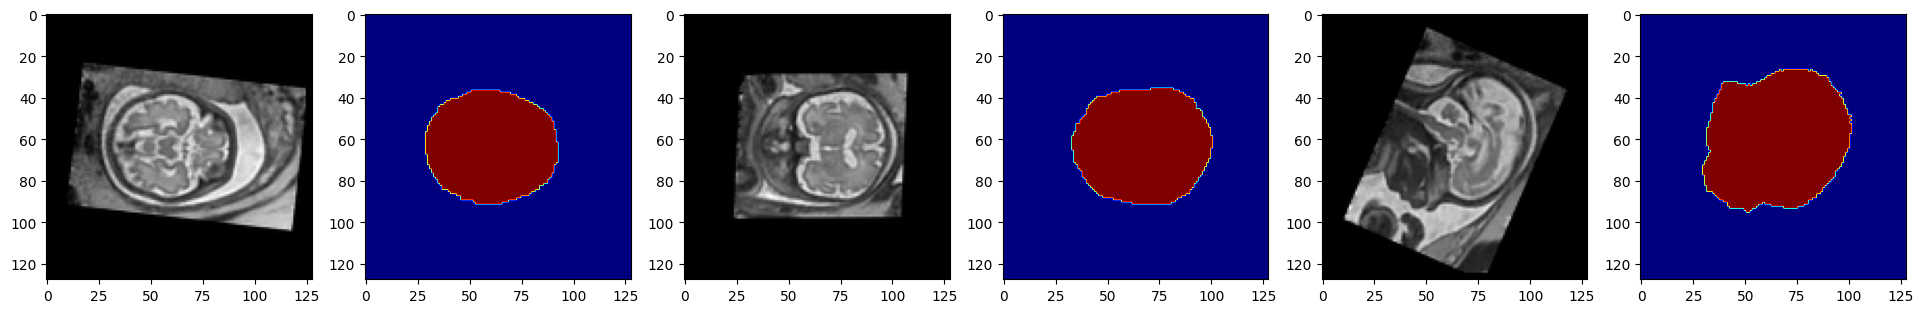

1 335-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


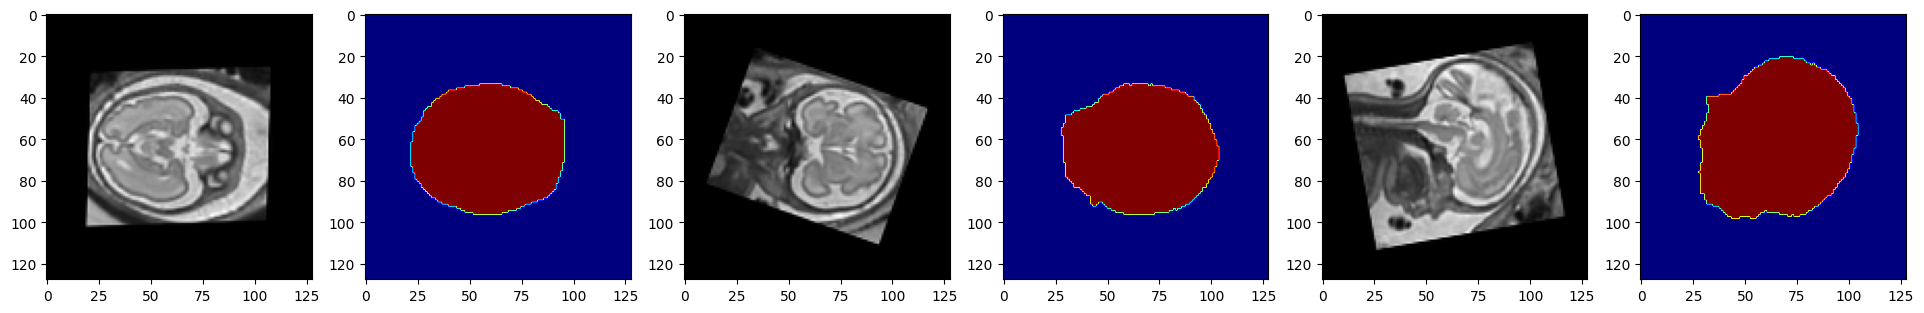

2 426-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


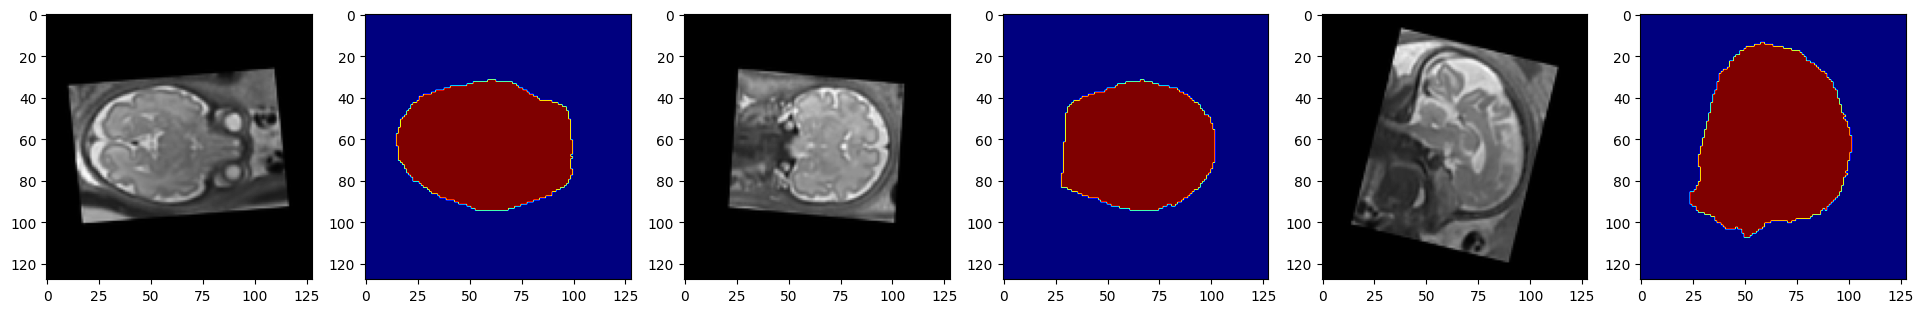

3 342-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


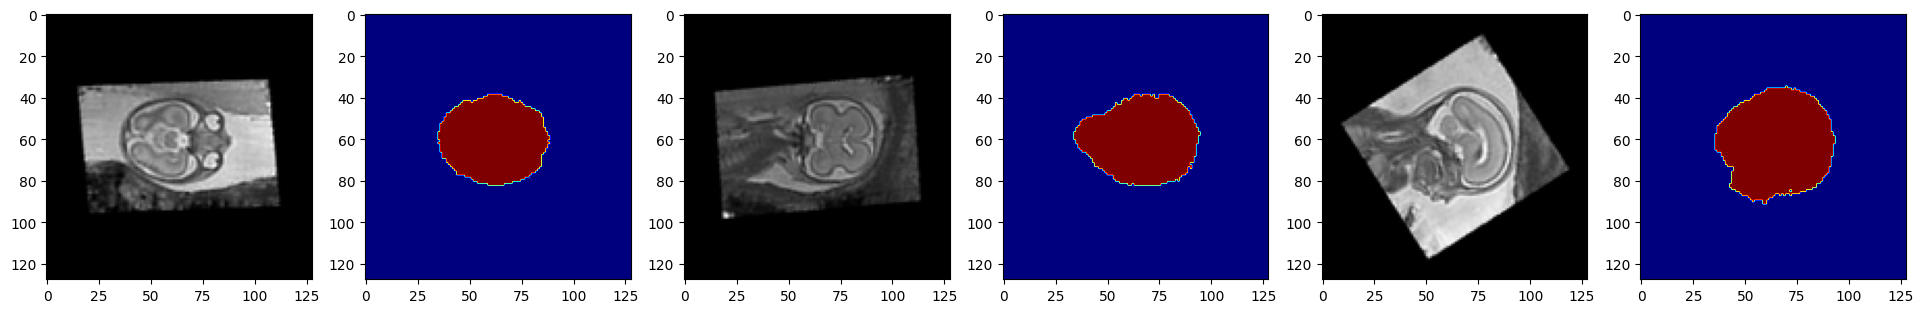

4 435-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


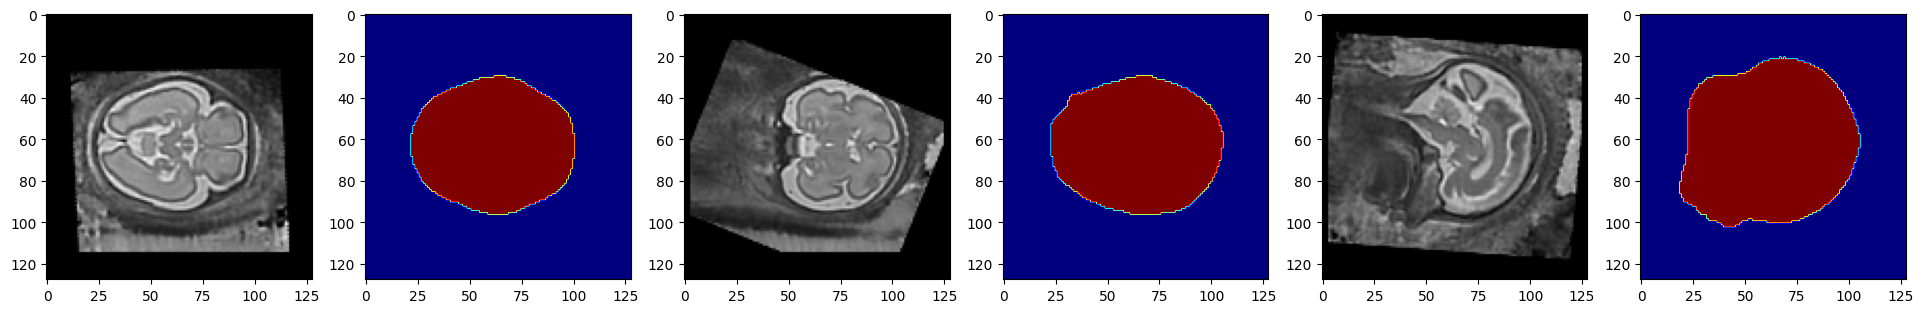

5 hist-136-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


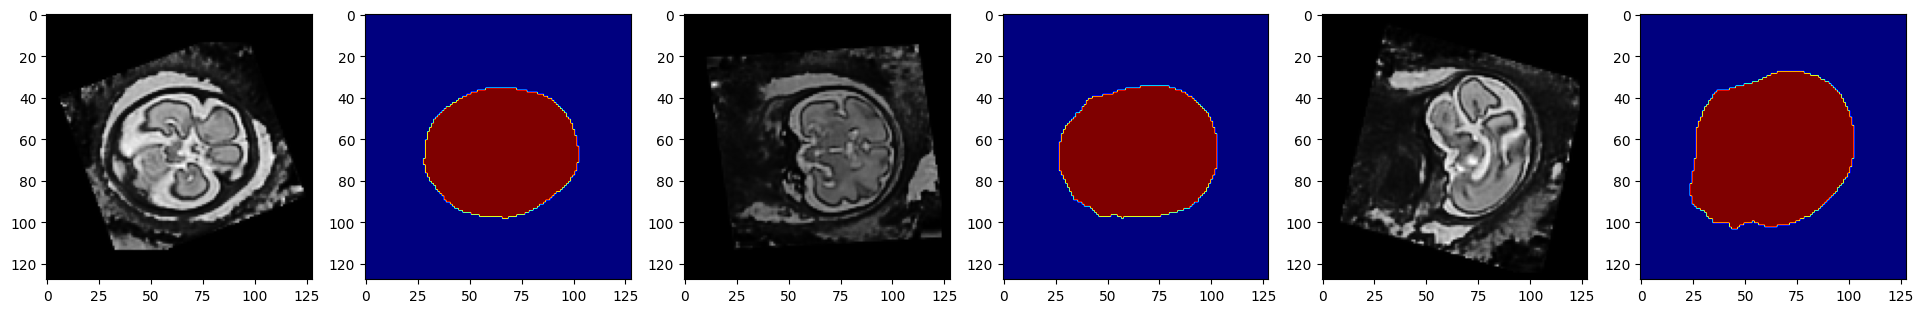

6 hist-214-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


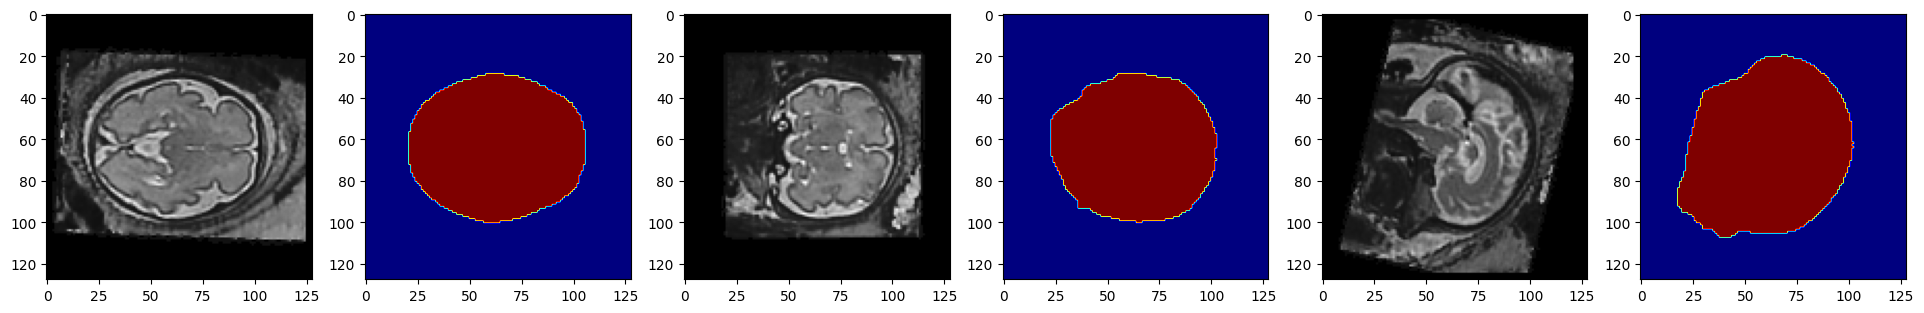

7 hist-236-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


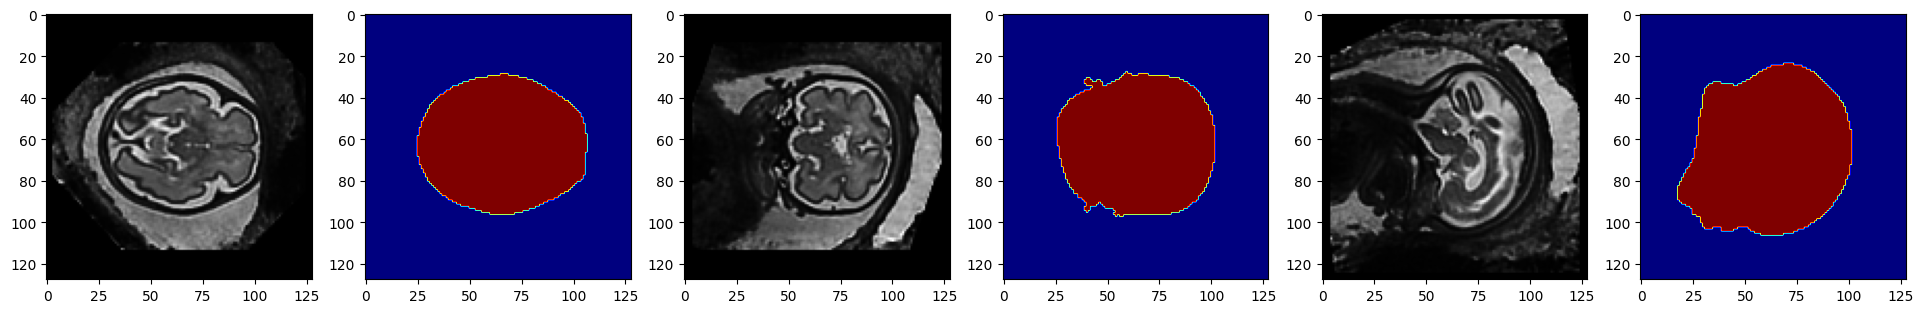

8 hist-253-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


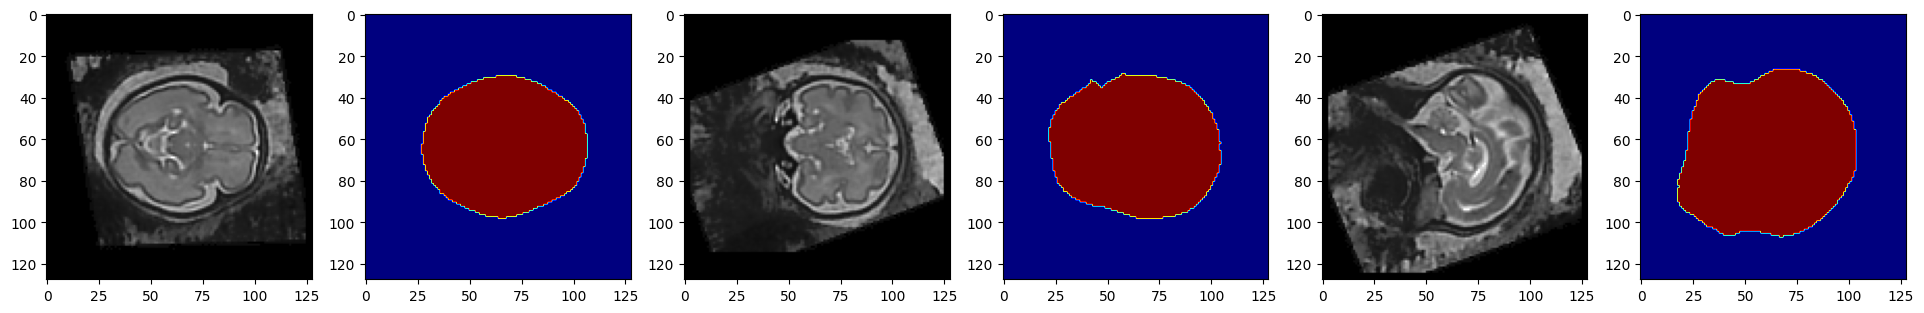

9 hist-275-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


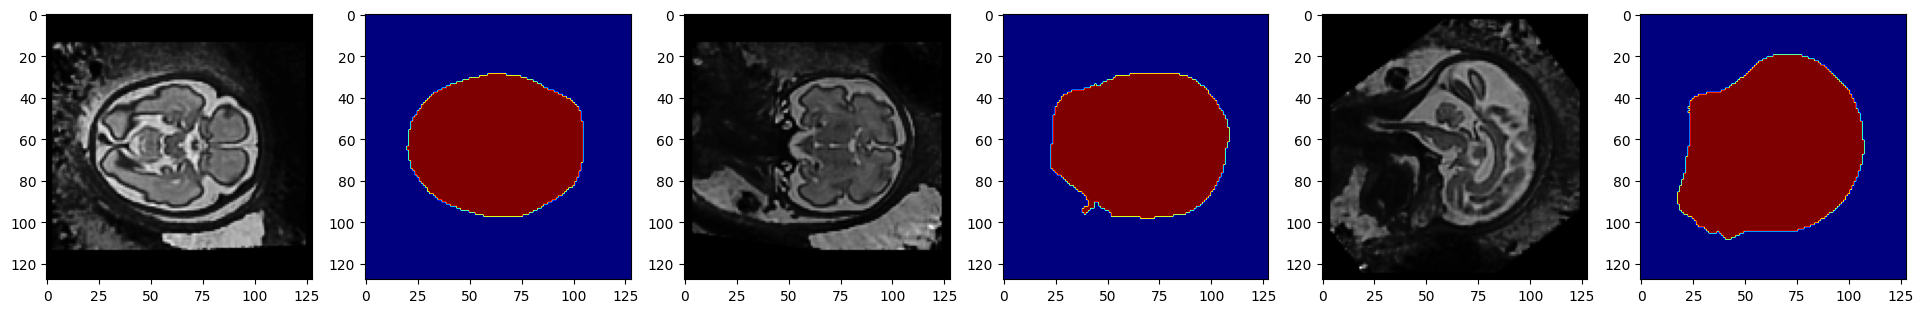

10 hist-292-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


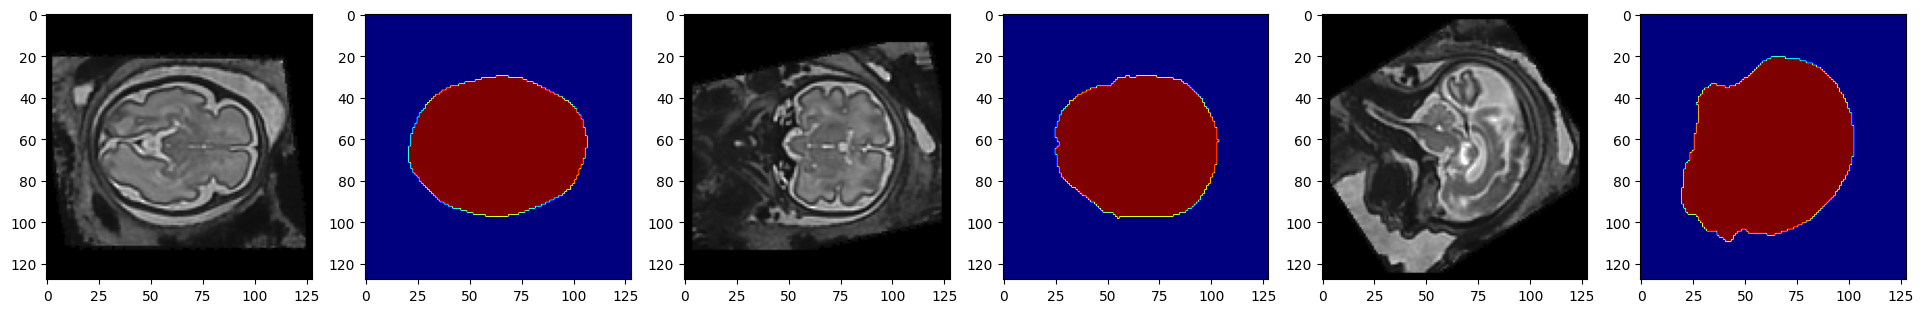

11 hist-355-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


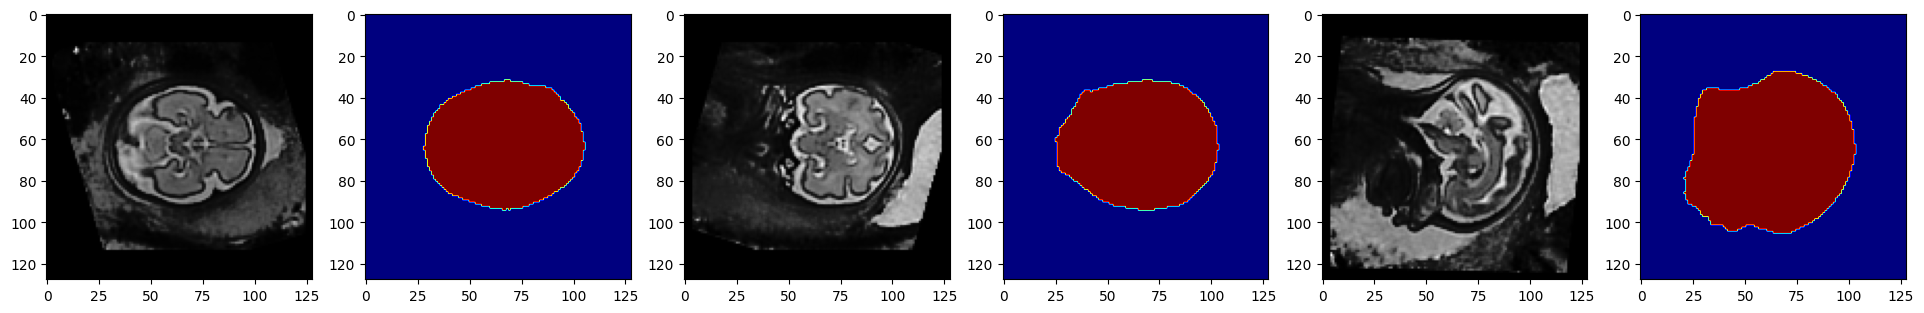

In [ ]:
s=round(img_dim/2)

for x in range(len(val_files)):

  case_num = x
  img_name = val_files[case_num]["label"]
  label_name = val_files[case_num]["label"]
  case_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
  case_in=val_ds[case_num]
  img = case_in["image"]
  label = case_in["label"]
  img_shape = img.shape
  label_shape = label.shape

  print(x, case_name, img_shape, label_shape)
  plt.figure("image", (24, 4))
  plt.subplot(1, 6, 1)
  plt.imshow(img[0, :, :, s], cmap="gray")
  plt.subplot(1, 6, 2)
  plt.imshow(label[0, :, :, s], cmap="jet")
  plt.subplot(1, 6, 3)
  plt.imshow(img[0, :, s, :], cmap="gray")
  plt.subplot(1, 6, 4)
  plt.imshow(label[0, :, s, :], cmap="jet")
  plt.subplot(1, 6, 5)
  plt.imshow(img[0, s, :, :], cmap="gray")
  plt.subplot(1, 6, 6)
  plt.imshow(label[0, s, :, :], cmap="jet")
  plt.show()

In [ ]:
# define the network using MONAI
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VNet(spatial_dims=3, in_channels=1, out_channels=class_num,
             act=('elu', {'inplace': True}),
             dropout_dim=3, bias=False).to(device)


loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [ ]:
def validation(epoch_iterator_val):
    model.eval()
    dice_vals = list()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (img_dim, img_dim, img_dim), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice = dice_metric.aggregate().item()
            dice_vals.append(dice)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice)
            )
        dice_metric.reset()
    mean_dice_val = np.mean(dice_vals)
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best,epochs_without_improvement):
    model.train()
    epoch_loss = 0
    step = 0
    total_training_time = 0
    patience = 10
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    # Initialize variables for early stopping
    start_time = time.time()  # Record the start time
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        # Check if early stopping condition is met
        if epochs_without_improvement >= patience:
          print("Early stopping: Model has not improved for {} epochs.".format(patience))
          epoch_iterator.close()
          epoch_iterator_val.close()
          break

        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            #CHANGE PER MODEL
            epoch_loss_values_vnet_withaug.append(epoch_loss)
            #CHANGE PER MODEL
            metric_values_vnet_withaug.append(dice_val)

            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                epochs_without_improvement = 0 # Reset patience counter
                print("Patience Counter has Been Reset")
                #CHANGE PER MODEL
                torch.save(
                    model.state_dict(), os.path.join(root_dir, (roi_type+"vnet_withaug_best_metric_model.pth"))
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
                print("Epochs Without Improvement:{}".format(epochs_without_improvement))

            else:
              epochs_without_improvement += 1
              #CHANGE PER MODEL
              torch.save(model.state_dict(), os.path.join(root_dir, (roi_type+"vnet_withaug_latest_metric_model.pth")))
              print("Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val))
              print("+1 Added to Patience Counter")
              print("Epochs Without Improvement:{}".format(epochs_without_improvement))



        global_step += 1

    # Training loop has completed, calculate the total training time
    end_time = time.time()
    epoch_iterator.close()

    total_training_time += end_time - start_time
    total_training_time_minutes = total_training_time / 60
    print(f"\nTotal Training Time: {total_training_time_minutes:.2f} minutes")
    print(f"Global step: {global_step}, Eval num: {eval_num}, Max iterations: {max_iterations}")
    return global_step, dice_val_best, global_step_best, epochs_without_improvement





In [ ]:
max_iterations = 30000
eval_num = 200
post_label = AsDiscrete(to_onehot=class_num)
post_pred = AsDiscrete(argmax=True, to_onehot=class_num)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epochs_without_improvement = 0
epoch_loss_values_vnet_withaug = []
metric_values_vnet_withaug = []

In [ ]:
# run training

while global_step < max_iterations:
    global_step, dice_val_best, global_step_best,epochs_without_improvement = train(
        global_step, train_loader, dice_val_best, global_step_best,epochs_without_improvement
    )

Training (81 / 30000 Steps) (loss=1.31466): 100%|██████████| 82/82 [04:20<00:00,  3.18s/it]



Total Training Time: 4.34 minutes
Global step: 82, Eval num: 200, Max iterations: 30000


Training (163 / 30000 Steps) (loss=1.19229): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 164, Eval num: 200, Max iterations: 30000


Validate (164 / 10 Steps) (dice=0.68137): 100%|██████████| 12/12 [00:06<00:00,  1.94it/s]


Patience Counter has Been Reset


Training (200 / 30000 Steps) (loss=1.19639):  45%|████▌     | 37/82 [01:13<02:49,  3.76s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5551487927635511 Current Avg. Dice: 0.5551487927635511
Epochs Without Improvement:0


Training (245 / 30000 Steps) (loss=0.33534): 100%|██████████| 82/82 [02:33<00:00,  1.87s/it]



Total Training Time: 2.55 minutes
Global step: 246, Eval num: 200, Max iterations: 30000


Training (327 / 30000 Steps) (loss=1.16157): 100%|██████████| 82/82 [02:26<00:00,  1.78s/it]



Total Training Time: 2.44 minutes
Global step: 328, Eval num: 200, Max iterations: 30000


Validate (328 / 10 Steps) (dice=0.74409): 100%|██████████| 12/12 [00:06<00:00,  1.97it/s]


Patience Counter has Been Reset


Training (400 / 30000 Steps) (loss=1.14764):  89%|████████▉ | 73/82 [02:16<00:33,  3.74s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6806859572728475 Current Avg. Dice: 0.6806859572728475
Epochs Without Improvement:0


Training (409 / 30000 Steps) (loss=0.74986): 100%|██████████| 82/82 [02:32<00:00,  1.87s/it]



Total Training Time: 2.55 minutes
Global step: 410, Eval num: 200, Max iterations: 30000


Training (491 / 30000 Steps) (loss=1.17549): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 492, Eval num: 200, Max iterations: 30000


Training (573 / 30000 Steps) (loss=1.09290): 100%|██████████| 82/82 [02:26<00:00,  1.78s/it]



Total Training Time: 2.44 minutes
Global step: 574, Eval num: 200, Max iterations: 30000


Validate (574 / 10 Steps) (dice=0.83675): 100%|██████████| 12/12 [00:06<00:00,  1.94it/s]


Patience Counter has Been Reset


Training (600 / 30000 Steps) (loss=1.04929):  33%|███▎      | 27/82 [00:55<03:27,  3.77s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8379439463218054 Current Avg. Dice: 0.8379439463218054
Epochs Without Improvement:0


Training (655 / 30000 Steps) (loss=0.35893): 100%|██████████| 82/82 [02:33<00:00,  1.87s/it]



Total Training Time: 2.56 minutes
Global step: 656, Eval num: 200, Max iterations: 30000


Training (737 / 30000 Steps) (loss=0.98013): 100%|██████████| 82/82 [02:26<00:00,  1.78s/it]



Total Training Time: 2.44 minutes
Global step: 738, Eval num: 200, Max iterations: 30000


Training (800 / 30000 Steps) (loss=0.96601):  77%|███████▋  | 63/82 [01:58<01:11,  3.77s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8379439463218054 Current Avg. Dice: 0.8075765520334244
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (819 / 30000 Steps) (loss=0.33155): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.54 minutes
Global step: 820, Eval num: 200, Max iterations: 30000


Training (901 / 30000 Steps) (loss=0.87896): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 902, Eval num: 200, Max iterations: 30000


Training (983 / 30000 Steps) (loss=1.03077): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 984, Eval num: 200, Max iterations: 30000


Validate (984 / 10 Steps) (dice=0.87137): 100%|██████████| 12/12 [00:06<00:00,  1.96it/s]


Patience Counter has Been Reset


Training (1000 / 30000 Steps) (loss=0.95316):  21%|██        | 17/82 [00:37<04:04,  3.76s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8521260519822439 Current Avg. Dice: 0.8521260519822439
Epochs Without Improvement:0


Training (1065 / 30000 Steps) (loss=0.23031): 100%|██████████| 82/82 [02:32<00:00,  1.87s/it]



Total Training Time: 2.55 minutes
Global step: 1066, Eval num: 200, Max iterations: 30000


Training (1147 / 30000 Steps) (loss=0.95393): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 1148, Eval num: 200, Max iterations: 30000


Training (1200 / 30000 Steps) (loss=0.85847):  65%|██████▍   | 53/82 [01:41<01:49,  3.77s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8521260519822439 Current Avg. Dice: 0.7919518699248632
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (1229 / 30000 Steps) (loss=0.29982): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.55 minutes
Global step: 1230, Eval num: 200, Max iterations: 30000


Training (1311 / 30000 Steps) (loss=0.86856): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.42 minutes
Global step: 1312, Eval num: 200, Max iterations: 30000


Training (1393 / 30000 Steps) (loss=0.86538): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 1394, Eval num: 200, Max iterations: 30000


Training (1400 / 30000 Steps) (loss=0.86568):   9%|▊         | 7/82 [00:19<04:53,  3.92s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8521260519822439 Current Avg. Dice: 0.7638330409924189
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (1475 / 30000 Steps) (loss=0.15184): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.55 minutes
Global step: 1476, Eval num: 200, Max iterations: 30000


Training (1557 / 30000 Steps) (loss=0.82611): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 1558, Eval num: 200, Max iterations: 30000


Training (1600 / 30000 Steps) (loss=0.76359):  52%|█████▏    | 43/82 [01:23<02:27,  3.77s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8521260519822439 Current Avg. Dice: 0.8013634979724884
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (1639 / 30000 Steps) (loss=0.30857): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.55 minutes
Global step: 1640, Eval num: 200, Max iterations: 30000


Training (1721 / 30000 Steps) (loss=0.76552): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.42 minutes
Global step: 1722, Eval num: 200, Max iterations: 30000


Training (1800 / 30000 Steps) (loss=0.70442):  96%|█████████▋| 79/82 [02:26<00:11,  3.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8521260519822439 Current Avg. Dice: 0.8357251137495041
+1 Added to Patience Counter
Epochs Without Improvement:4


Training (1803 / 30000 Steps) (loss=0.66898): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.54 minutes
Global step: 1804, Eval num: 200, Max iterations: 30000


Training (1885 / 30000 Steps) (loss=0.66144): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 1886, Eval num: 200, Max iterations: 30000


Training (1967 / 30000 Steps) (loss=0.83538): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.42 minutes
Global step: 1968, Eval num: 200, Max iterations: 30000


Training (2000 / 30000 Steps) (loss=0.87525):  40%|████      | 33/82 [01:05<03:02,  3.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8521260519822439 Current Avg. Dice: 0.8154074599345525
+1 Added to Patience Counter
Epochs Without Improvement:5


Training (2049 / 30000 Steps) (loss=0.19860): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.55 minutes
Global step: 2050, Eval num: 200, Max iterations: 30000


Training (2131 / 30000 Steps) (loss=0.90848): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 2132, Eval num: 200, Max iterations: 30000


Training (2200 / 30000 Steps) (loss=0.62478):  84%|████████▍ | 69/82 [02:09<00:48,  3.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8521260519822439 Current Avg. Dice: 0.8064914147059122
+1 Added to Patience Counter
Epochs Without Improvement:6


Training (2213 / 30000 Steps) (loss=0.40090): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.54 minutes
Global step: 2214, Eval num: 200, Max iterations: 30000


Training (2295 / 30000 Steps) (loss=0.77386): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 2296, Eval num: 200, Max iterations: 30000


Training (2377 / 30000 Steps) (loss=0.57170): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 2378, Eval num: 200, Max iterations: 30000


Training (2400 / 30000 Steps) (loss=0.64588):  28%|██▊       | 23/82 [00:47<03:39,  3.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8521260519822439 Current Avg. Dice: 0.810475692152977
+1 Added to Patience Counter
Epochs Without Improvement:7


Training (2459 / 30000 Steps) (loss=0.15535): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.54 minutes
Global step: 2460, Eval num: 200, Max iterations: 30000


Training (2541 / 30000 Steps) (loss=0.62109): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 2542, Eval num: 200, Max iterations: 30000


Validate (2542 / 10 Steps) (dice=0.88207): 100%|██████████| 12/12 [00:06<00:00,  1.95it/s]


Patience Counter has Been Reset


Training (2600 / 30000 Steps) (loss=0.55677):  72%|███████▏  | 59/82 [01:51<01:26,  3.74s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8615322560071945 Current Avg. Dice: 0.8615322560071945
Epochs Without Improvement:0


Training (2623 / 30000 Steps) (loss=0.30277): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.55 minutes
Global step: 2624, Eval num: 200, Max iterations: 30000


Training (2705 / 30000 Steps) (loss=0.56852): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 2706, Eval num: 200, Max iterations: 30000


Training (2787 / 30000 Steps) (loss=0.49024): 100%|██████████| 82/82 [02:26<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 2788, Eval num: 200, Max iterations: 30000


Training (2800 / 30000 Steps) (loss=0.57301):  16%|█▌        | 13/82 [00:30<04:19,  3.76s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8615322560071945 Current Avg. Dice: 0.8318156898021698
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (2869 / 30000 Steps) (loss=0.18887): 100%|██████████| 82/82 [02:32<00:00,  1.87s/it]



Total Training Time: 2.55 minutes
Global step: 2870, Eval num: 200, Max iterations: 30000


Training (2951 / 30000 Steps) (loss=0.53349): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.43 minutes
Global step: 2952, Eval num: 200, Max iterations: 30000


Validate (2952 / 10 Steps) (dice=0.88409): 100%|██████████| 12/12 [00:06<00:00,  1.97it/s]


Patience Counter has Been Reset


Training (3000 / 30000 Steps) (loss=0.57068):  60%|█████▉    | 49/82 [01:34<02:03,  3.73s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8719336837530136 Current Avg. Dice: 0.8719336837530136
Epochs Without Improvement:0


Training (3033 / 30000 Steps) (loss=0.32612): 100%|██████████| 82/82 [02:33<00:00,  1.87s/it]



Total Training Time: 2.55 minutes
Global step: 3034, Eval num: 200, Max iterations: 30000


Training (3115 / 30000 Steps) (loss=0.52733): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.42 minutes
Global step: 3116, Eval num: 200, Max iterations: 30000


Training (3197 / 30000 Steps) (loss=0.51788): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 3198, Eval num: 200, Max iterations: 30000


Training (3200 / 30000 Steps) (loss=0.42097):   4%|▎         | 3/82 [00:13<06:37,  5.03s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8719336837530136 Current Avg. Dice: 0.8683403978745142
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (3279 / 30000 Steps) (loss=0.16142): 100%|██████████| 82/82 [02:33<00:00,  1.87s/it]



Total Training Time: 2.55 minutes
Global step: 3280, Eval num: 200, Max iterations: 30000


Training (3361 / 30000 Steps) (loss=0.40835): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.42 minutes
Global step: 3362, Eval num: 200, Max iterations: 30000


Validate (3362 / 10 Steps) (dice=0.90076): 100%|██████████| 12/12 [00:06<00:00,  1.93it/s]


Patience Counter has Been Reset


Training (3400 / 30000 Steps) (loss=0.41415):  48%|████▊     | 39/82 [01:16<02:46,  3.88s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8839633812506994 Current Avg. Dice: 0.8839633812506994
Epochs Without Improvement:0


Training (3443 / 30000 Steps) (loss=0.29988): 100%|██████████| 82/82 [02:33<00:00,  1.87s/it]



Total Training Time: 2.55 minutes
Global step: 3444, Eval num: 200, Max iterations: 30000


Training (3525 / 30000 Steps) (loss=0.41338): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.43 minutes
Global step: 3526, Eval num: 200, Max iterations: 30000


Training (3600 / 30000 Steps) (loss=0.37479):  91%|█████████▏| 75/82 [02:19<00:26,  3.81s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8839633812506994 Current Avg. Dice: 0.8810263226429621
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (3607 / 30000 Steps) (loss=0.32670): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.54 minutes
Global step: 3608, Eval num: 200, Max iterations: 30000


Training (3689 / 30000 Steps) (loss=0.63642): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 3690, Eval num: 200, Max iterations: 30000


Training (3771 / 30000 Steps) (loss=0.65189): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 3772, Eval num: 200, Max iterations: 30000


Training (3800 / 30000 Steps) (loss=0.32010):  35%|███▌      | 29/82 [00:59<03:21,  3.80s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8839633812506994 Current Avg. Dice: 0.8445724050203959
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (3853 / 30000 Steps) (loss=0.35457): 100%|██████████| 82/82 [02:33<00:00,  1.87s/it]



Total Training Time: 2.55 minutes
Global step: 3854, Eval num: 200, Max iterations: 30000


Training (3935 / 30000 Steps) (loss=0.34434): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 3936, Eval num: 200, Max iterations: 30000


Training (4000 / 30000 Steps) (loss=0.28617):  79%|███████▉  | 65/82 [02:02<01:03,  3.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8839633812506994 Current Avg. Dice: 0.8738916714986166
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (4017 / 30000 Steps) (loss=0.30252): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.54 minutes
Global step: 4018, Eval num: 200, Max iterations: 30000


Training (4099 / 30000 Steps) (loss=0.34225): 100%|██████████| 82/82 [02:26<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 4100, Eval num: 200, Max iterations: 30000


Training (4181 / 30000 Steps) (loss=0.30538): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 4182, Eval num: 200, Max iterations: 30000


Validate (4182 / 10 Steps) (dice=0.90510): 100%|██████████| 12/12 [00:06<00:00,  1.96it/s]


Patience Counter has Been Reset


Training (4200 / 30000 Steps) (loss=0.38245):  23%|██▎       | 19/82 [00:41<03:55,  3.73s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8900497754414877 Current Avg. Dice: 0.8900497754414877
Epochs Without Improvement:0


Training (4263 / 30000 Steps) (loss=0.33250): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.55 minutes
Global step: 4264, Eval num: 200, Max iterations: 30000


Training (4345 / 30000 Steps) (loss=0.32356): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 4346, Eval num: 200, Max iterations: 30000


Validate (4346 / 10 Steps) (dice=0.91709): 100%|██████████| 12/12 [00:06<00:00,  1.98it/s]


Patience Counter has Been Reset


Training (4400 / 30000 Steps) (loss=0.29529):  67%|██████▋   | 55/82 [01:44<01:40,  3.71s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9037265280882517 Current Avg. Dice: 0.9037265280882517
Epochs Without Improvement:0


Training (4427 / 30000 Steps) (loss=0.25748): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.54 minutes
Global step: 4428, Eval num: 200, Max iterations: 30000


Training (4509 / 30000 Steps) (loss=0.55949): 100%|██████████| 82/82 [02:26<00:00,  1.78s/it]



Total Training Time: 2.44 minutes
Global step: 4510, Eval num: 200, Max iterations: 30000


Training (4591 / 30000 Steps) (loss=0.25642): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.43 minutes
Global step: 4592, Eval num: 200, Max iterations: 30000


Training (4600 / 30000 Steps) (loss=0.26127):  11%|█         | 9/82 [00:23<04:40,  3.85s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9037265280882517 Current Avg. Dice: 0.9004932592312495
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (4673 / 30000 Steps) (loss=0.21954): 100%|██████████| 82/82 [02:33<00:00,  1.87s/it]



Total Training Time: 2.56 minutes
Global step: 4674, Eval num: 200, Max iterations: 30000


Training (4755 / 30000 Steps) (loss=0.27175): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 4756, Eval num: 200, Max iterations: 30000


Validate (4756 / 10 Steps) (dice=0.92088): 100%|██████████| 12/12 [00:06<00:00,  1.96it/s]


Patience Counter has Been Reset


Training (4800 / 30000 Steps) (loss=0.26628):  55%|█████▍    | 45/82 [01:27<02:18,  3.75s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9042150378227234 Current Avg. Dice: 0.9042150378227234
Epochs Without Improvement:0


Training (4837 / 30000 Steps) (loss=0.19852): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.55 minutes
Global step: 4838, Eval num: 200, Max iterations: 30000


Training (4919 / 30000 Steps) (loss=0.27191): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.42 minutes
Global step: 4920, Eval num: 200, Max iterations: 30000


Training (5000 / 30000 Steps) (loss=0.27525):  99%|█████████▉| 81/82 [02:30<00:03,  3.76s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9042150378227234 Current Avg. Dice: 0.9013638844092687
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (5001 / 30000 Steps) (loss=0.27443): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.54 minutes
Global step: 5002, Eval num: 200, Max iterations: 30000


Training (5083 / 30000 Steps) (loss=0.24494): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 5084, Eval num: 200, Max iterations: 30000


Training (5165 / 30000 Steps) (loss=0.23727): 100%|██████████| 82/82 [02:26<00:00,  1.79s/it]



Total Training Time: 2.44 minutes
Global step: 5166, Eval num: 200, Max iterations: 30000


Training (5200 / 30000 Steps) (loss=0.25914):  43%|████▎     | 35/82 [01:09<02:55,  3.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9042150378227234 Current Avg. Dice: 0.8815716703732809
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (5247 / 30000 Steps) (loss=0.21999): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.54 minutes
Global step: 5248, Eval num: 200, Max iterations: 30000


Training (5329 / 30000 Steps) (loss=0.27055): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.42 minutes
Global step: 5330, Eval num: 200, Max iterations: 30000


Training (5400 / 30000 Steps) (loss=0.38929):  87%|████████▋ | 71/82 [02:12<00:41,  3.78s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9042150378227234 Current Avg. Dice: 0.9012685120105743
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (5411 / 30000 Steps) (loss=0.23722): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.54 minutes
Global step: 5412, Eval num: 200, Max iterations: 30000


Training (5493 / 30000 Steps) (loss=0.19606): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.42 minutes
Global step: 5494, Eval num: 200, Max iterations: 30000


Training (5575 / 30000 Steps) (loss=0.25410): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.43 minutes
Global step: 5576, Eval num: 200, Max iterations: 30000


Validate (5576 / 10 Steps) (dice=0.92061): 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]


Patience Counter has Been Reset


Training (5600 / 30000 Steps) (loss=0.25651):  30%|███       | 25/82 [00:52<03:37,  3.81s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9063012550274531 Current Avg. Dice: 0.9063012550274531
Epochs Without Improvement:0


Training (5657 / 30000 Steps) (loss=0.16445): 100%|██████████| 82/82 [02:33<00:00,  1.87s/it]



Total Training Time: 2.56 minutes
Global step: 5658, Eval num: 200, Max iterations: 30000


Training (5739 / 30000 Steps) (loss=0.19012): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 5740, Eval num: 200, Max iterations: 30000


Training (5800 / 30000 Steps) (loss=0.22493):  74%|███████▍  | 61/82 [01:55<01:18,  3.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9063012550274531 Current Avg. Dice: 0.8954715728759766
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (5821 / 30000 Steps) (loss=0.17841): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.54 minutes
Global step: 5822, Eval num: 200, Max iterations: 30000


Training (5903 / 30000 Steps) (loss=0.26244): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 5904, Eval num: 200, Max iterations: 30000


Training (5985 / 30000 Steps) (loss=0.20330): 100%|██████████| 82/82 [02:26<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 5986, Eval num: 200, Max iterations: 30000


Validate (5986 / 10 Steps) (dice=0.92340): 100%|██████████| 12/12 [00:06<00:00,  1.92it/s]


Patience Counter has Been Reset


Training (6000 / 30000 Steps) (loss=0.16222):  18%|█▊        | 15/82 [00:34<04:13,  3.79s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9068190703789393 Current Avg. Dice: 0.9068190703789393
Epochs Without Improvement:0


Training (6067 / 30000 Steps) (loss=0.18098): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.55 minutes
Global step: 6068, Eval num: 200, Max iterations: 30000


Training (6149 / 30000 Steps) (loss=0.19559): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.43 minutes
Global step: 6150, Eval num: 200, Max iterations: 30000


Validate (6150 / 10 Steps) (dice=0.92632): 100%|██████████| 12/12 [00:06<00:00,  1.96it/s]


Patience Counter has Been Reset


Training (6200 / 30000 Steps) (loss=0.21045):  62%|██████▏   | 51/82 [01:37<01:55,  3.74s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9118685672680537 Current Avg. Dice: 0.9118685672680537
Epochs Without Improvement:0


Training (6231 / 30000 Steps) (loss=0.23130): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.55 minutes
Global step: 6232, Eval num: 200, Max iterations: 30000


Training (6313 / 30000 Steps) (loss=0.16672): 100%|██████████| 82/82 [02:24<00:00,  1.77s/it]



Total Training Time: 2.42 minutes
Global step: 6314, Eval num: 200, Max iterations: 30000


Training (6395 / 30000 Steps) (loss=0.19044): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.43 minutes
Global step: 6396, Eval num: 200, Max iterations: 30000


Training (6400 / 30000 Steps) (loss=0.25669):   6%|▌         | 5/82 [00:16<05:25,  4.23s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9118685672680537 Current Avg. Dice: 0.9036512325207392
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (6477 / 30000 Steps) (loss=0.17733): 100%|██████████| 82/82 [02:32<00:00,  1.87s/it]



Total Training Time: 2.55 minutes
Global step: 6478, Eval num: 200, Max iterations: 30000


Training (6559 / 30000 Steps) (loss=0.18610): 100%|██████████| 82/82 [02:26<00:00,  1.78s/it]



Total Training Time: 2.44 minutes
Global step: 6560, Eval num: 200, Max iterations: 30000


Training (6600 / 30000 Steps) (loss=0.24868):  50%|█████     | 41/82 [01:19<02:33,  3.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9118685672680537 Current Avg. Dice: 0.910598541299502
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (6641 / 30000 Steps) (loss=0.14654): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.55 minutes
Global step: 6642, Eval num: 200, Max iterations: 30000


Training (6723 / 30000 Steps) (loss=0.14286): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 6724, Eval num: 200, Max iterations: 30000


Training (6800 / 30000 Steps) (loss=0.18660):  94%|█████████▍| 77/82 [02:23<00:18,  3.76s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9118685672680537 Current Avg. Dice: 0.908947711189588
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (6805 / 30000 Steps) (loss=0.14673): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.55 minutes
Global step: 6806, Eval num: 200, Max iterations: 30000


Training (6887 / 30000 Steps) (loss=0.18331): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 6888, Eval num: 200, Max iterations: 30000


Training (6969 / 30000 Steps) (loss=0.18794): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 6970, Eval num: 200, Max iterations: 30000


Validate (6970 / 10 Steps) (dice=0.92732): 100%|██████████| 12/12 [00:06<00:00,  1.94it/s]


Patience Counter has Been Reset


Training (7000 / 30000 Steps) (loss=0.13914):  38%|███▊      | 31/82 [01:02<03:12,  3.77s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9141708860794703 Current Avg. Dice: 0.9141708860794703
Epochs Without Improvement:0


Training (7051 / 30000 Steps) (loss=0.13858): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.55 minutes
Global step: 7052, Eval num: 200, Max iterations: 30000


Training (7133 / 30000 Steps) (loss=0.15601): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.42 minutes
Global step: 7134, Eval num: 200, Max iterations: 30000


Validate (7134 / 10 Steps) (dice=0.92815): 100%|██████████| 12/12 [00:06<00:00,  1.97it/s]


Patience Counter has Been Reset


Training (7200 / 30000 Steps) (loss=0.16256):  82%|████████▏ | 67/82 [02:05<00:55,  3.72s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9171511083841324 Current Avg. Dice: 0.9171511083841324
Epochs Without Improvement:0


Training (7215 / 30000 Steps) (loss=0.17246): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.55 minutes
Global step: 7216, Eval num: 200, Max iterations: 30000


Training (7297 / 30000 Steps) (loss=0.11460): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.42 minutes
Global step: 7298, Eval num: 200, Max iterations: 30000


Training (7379 / 30000 Steps) (loss=0.13289): 100%|██████████| 82/82 [02:24<00:00,  1.77s/it]



Total Training Time: 2.42 minutes
Global step: 7380, Eval num: 200, Max iterations: 30000


Training (7400 / 30000 Steps) (loss=0.17729):  26%|██▌       | 21/82 [00:45<03:53,  3.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9171511083841324 Current Avg. Dice: 0.9160162210464478
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (7461 / 30000 Steps) (loss=0.16804): 100%|██████████| 82/82 [02:33<00:00,  1.87s/it]



Total Training Time: 2.55 minutes
Global step: 7462, Eval num: 200, Max iterations: 30000


Training (7543 / 30000 Steps) (loss=0.15019): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 7544, Eval num: 200, Max iterations: 30000


Validate (7544 / 10 Steps) (dice=0.93366): 100%|██████████| 12/12 [00:06<00:00,  1.87it/s]


Patience Counter has Been Reset


Training (7600 / 30000 Steps) (loss=0.17197):  70%|██████▉   | 57/82 [01:48<01:35,  3.84s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9199318339427313 Current Avg. Dice: 0.9199318339427313
Epochs Without Improvement:0


Training (7625 / 30000 Steps) (loss=0.17863): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.54 minutes
Global step: 7626, Eval num: 200, Max iterations: 30000


Training (7707 / 30000 Steps) (loss=0.37252): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 7708, Eval num: 200, Max iterations: 30000


Training (7789 / 30000 Steps) (loss=0.14587): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 7790, Eval num: 200, Max iterations: 30000


Validate (7790 / 10 Steps) (dice=0.93580): 100%|██████████| 12/12 [00:06<00:00,  1.94it/s]


Patience Counter has Been Reset


Training (7800 / 30000 Steps) (loss=0.14151):  13%|█▎        | 11/82 [00:27<04:31,  3.82s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9232567648092905 Current Avg. Dice: 0.9232567648092905
Epochs Without Improvement:0


Training (7871 / 30000 Steps) (loss=0.12841): 100%|██████████| 82/82 [02:33<00:00,  1.87s/it]



Total Training Time: 2.55 minutes
Global step: 7872, Eval num: 200, Max iterations: 30000


Training (7953 / 30000 Steps) (loss=0.14325): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.43 minutes
Global step: 7954, Eval num: 200, Max iterations: 30000


Validate (7954 / 10 Steps) (dice=0.93802): 100%|██████████| 12/12 [00:06<00:00,  1.94it/s]


Patience Counter has Been Reset


Training (8000 / 30000 Steps) (loss=0.14757):  57%|█████▋    | 47/82 [01:30<02:11,  3.76s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9259550919135412 Current Avg. Dice: 0.9259550919135412
Epochs Without Improvement:0


Training (8035 / 30000 Steps) (loss=0.21105): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.55 minutes
Global step: 8036, Eval num: 200, Max iterations: 30000


Training (8117 / 30000 Steps) (loss=0.11889): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.42 minutes
Global step: 8118, Eval num: 200, Max iterations: 30000


Training (8199 / 30000 Steps) (loss=0.17178): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.42 minutes
Global step: 8200, Eval num: 200, Max iterations: 30000


Training (8200 / 30000 Steps) (loss=0.11894):   1%|          | 1/82 [00:09<12:47,  9.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9259550919135412 Current Avg. Dice: 0.9232376366853714
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (8281 / 30000 Steps) (loss=0.19926): 100%|██████████| 82/82 [02:33<00:00,  1.87s/it]



Total Training Time: 2.55 minutes
Global step: 8282, Eval num: 200, Max iterations: 30000


Training (8363 / 30000 Steps) (loss=0.15394): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 8364, Eval num: 200, Max iterations: 30000


Validate (8364 / 10 Steps) (dice=0.93973): 100%|██████████| 12/12 [00:06<00:00,  1.97it/s]


Patience Counter has Been Reset


Training (8400 / 30000 Steps) (loss=0.15495):  45%|████▌     | 37/82 [01:12<02:47,  3.73s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9292515615622202 Current Avg. Dice: 0.9292515615622202
Epochs Without Improvement:0


Training (8445 / 30000 Steps) (loss=0.20119): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.54 minutes
Global step: 8446, Eval num: 200, Max iterations: 30000


Training (8527 / 30000 Steps) (loss=0.20100): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.42 minutes
Global step: 8528, Eval num: 200, Max iterations: 30000


Training (8600 / 30000 Steps) (loss=0.12120):  89%|████████▉ | 73/82 [02:16<00:33,  3.76s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9292515615622202 Current Avg. Dice: 0.9256310810645422
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (8609 / 30000 Steps) (loss=0.12500): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.54 minutes
Global step: 8610, Eval num: 200, Max iterations: 30000


Training (8691 / 30000 Steps) (loss=0.25843): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.43 minutes
Global step: 8692, Eval num: 200, Max iterations: 30000


Training (8773 / 30000 Steps) (loss=0.29221): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.42 minutes
Global step: 8774, Eval num: 200, Max iterations: 30000


Training (8800 / 30000 Steps) (loss=0.09837):  33%|███▎      | 27/82 [00:55<03:27,  3.78s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9292515615622202 Current Avg. Dice: 0.9145226975282034
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (8855 / 30000 Steps) (loss=0.25065): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.55 minutes
Global step: 8856, Eval num: 200, Max iterations: 30000


Training (8937 / 30000 Steps) (loss=0.13618): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.42 minutes
Global step: 8938, Eval num: 200, Max iterations: 30000


Training (9000 / 30000 Steps) (loss=0.16156):  77%|███████▋  | 63/82 [01:58<01:11,  3.77s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9292515615622202 Current Avg. Dice: 0.920982708533605
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (9019 / 30000 Steps) (loss=0.17805): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.54 minutes
Global step: 9020, Eval num: 200, Max iterations: 30000


Training (9101 / 30000 Steps) (loss=0.13597): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.42 minutes
Global step: 9102, Eval num: 200, Max iterations: 30000


Training (9183 / 30000 Steps) (loss=0.11563): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.42 minutes
Global step: 9184, Eval num: 200, Max iterations: 30000


Validate (9184 / 10 Steps) (dice=0.94421): 100%|██████████| 12/12 [00:06<00:00,  1.98it/s]


Patience Counter has Been Reset


Training (9200 / 30000 Steps) (loss=0.13566):  21%|██        | 17/82 [00:37<04:03,  3.75s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9331732392311096 Current Avg. Dice: 0.9331732392311096
Epochs Without Improvement:0


Training (9265 / 30000 Steps) (loss=0.17929): 100%|██████████| 82/82 [02:33<00:00,  1.87s/it]



Total Training Time: 2.55 minutes
Global step: 9266, Eval num: 200, Max iterations: 30000


Training (9347 / 30000 Steps) (loss=0.10105): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.42 minutes
Global step: 9348, Eval num: 200, Max iterations: 30000


Training (9400 / 30000 Steps) (loss=0.18406):  65%|██████▍   | 53/82 [01:41<01:50,  3.82s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9331732392311096 Current Avg. Dice: 0.9323431899150213
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (9429 / 30000 Steps) (loss=0.15385): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.55 minutes
Global step: 9430, Eval num: 200, Max iterations: 30000


Training (9511 / 30000 Steps) (loss=0.13351): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 9512, Eval num: 200, Max iterations: 30000


Training (9593 / 30000 Steps) (loss=0.14160): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 9594, Eval num: 200, Max iterations: 30000


Validate (9594 / 10 Steps) (dice=0.94636): 100%|██████████| 12/12 [00:06<00:00,  1.96it/s]


Patience Counter has Been Reset


Training (9600 / 30000 Steps) (loss=0.11789):   9%|▊         | 7/82 [00:20<04:58,  3.98s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9356858680645624 Current Avg. Dice: 0.9356858680645624
Epochs Without Improvement:0


Training (9675 / 30000 Steps) (loss=0.12931): 100%|██████████| 82/82 [02:33<00:00,  1.87s/it]



Total Training Time: 2.55 minutes
Global step: 9676, Eval num: 200, Max iterations: 30000


Training (9757 / 30000 Steps) (loss=0.12866): 100%|██████████| 82/82 [02:26<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 9758, Eval num: 200, Max iterations: 30000


Training (9800 / 30000 Steps) (loss=0.09982):  52%|█████▏    | 43/82 [01:23<02:25,  3.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9356858680645624 Current Avg. Dice: 0.9325626343488693
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (9839 / 30000 Steps) (loss=0.11273): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.55 minutes
Global step: 9840, Eval num: 200, Max iterations: 30000


Training (9921 / 30000 Steps) (loss=0.10629): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.42 minutes
Global step: 9922, Eval num: 200, Max iterations: 30000


Training (10000 / 30000 Steps) (loss=0.15845):  96%|█████████▋| 79/82 [02:27<00:11,  3.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9356858680645624 Current Avg. Dice: 0.9330881237983704
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (10003 / 30000 Steps) (loss=0.11176): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.54 minutes
Global step: 10004, Eval num: 200, Max iterations: 30000


Training (10085 / 30000 Steps) (loss=0.14077): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 10086, Eval num: 200, Max iterations: 30000


Training (10167 / 30000 Steps) (loss=0.15768): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 10168, Eval num: 200, Max iterations: 30000


Training (10200 / 30000 Steps) (loss=0.08476):  40%|████      | 33/82 [01:05<03:02,  3.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9356858680645624 Current Avg. Dice: 0.9355798959732056
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (10249 / 30000 Steps) (loss=0.14597): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.55 minutes
Global step: 10250, Eval num: 200, Max iterations: 30000


Training (10331 / 30000 Steps) (loss=0.28720): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.42 minutes
Global step: 10332, Eval num: 200, Max iterations: 30000


Validate (10332 / 10 Steps) (dice=0.94828): 100%|██████████| 12/12 [00:06<00:00,  1.95it/s]


Patience Counter has Been Reset


Training (10400 / 30000 Steps) (loss=0.13933):  84%|████████▍ | 69/82 [02:09<00:48,  3.75s/it]

Model Was Saved ! Current Best Avg. Dice: 0.937564805150032 Current Avg. Dice: 0.937564805150032
Epochs Without Improvement:0


Training (10413 / 30000 Steps) (loss=0.16015): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.54 minutes
Global step: 10414, Eval num: 200, Max iterations: 30000


Training (10495 / 30000 Steps) (loss=0.09140): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.42 minutes
Global step: 10496, Eval num: 200, Max iterations: 30000


Training (10577 / 30000 Steps) (loss=0.10807): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.42 minutes
Global step: 10578, Eval num: 200, Max iterations: 30000


Training (10600 / 30000 Steps) (loss=0.08783):  28%|██▊       | 23/82 [00:48<03:42,  3.76s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.937564805150032 Current Avg. Dice: 0.9359214057524999
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (10659 / 30000 Steps) (loss=0.08374): 100%|██████████| 82/82 [02:33<00:00,  1.87s/it]



Total Training Time: 2.55 minutes
Global step: 10660, Eval num: 200, Max iterations: 30000


Training (10741 / 30000 Steps) (loss=0.11149): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.43 minutes
Global step: 10742, Eval num: 200, Max iterations: 30000


Validate (10742 / 10 Steps) (dice=0.95370): 100%|██████████| 12/12 [00:06<00:00,  1.88it/s]


Patience Counter has Been Reset


Training (10800 / 30000 Steps) (loss=0.30691):  72%|███████▏  | 59/82 [01:51<01:27,  3.81s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9425791352987289 Current Avg. Dice: 0.9425791352987289
Epochs Without Improvement:0


Training (10823 / 30000 Steps) (loss=0.16381): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.55 minutes
Global step: 10824, Eval num: 200, Max iterations: 30000


Training (10905 / 30000 Steps) (loss=0.11898): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.42 minutes
Global step: 10906, Eval num: 200, Max iterations: 30000


Training (10987 / 30000 Steps) (loss=0.11443): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 10988, Eval num: 200, Max iterations: 30000


Validate (10988 / 10 Steps) (dice=0.95100): 100%|██████████| 12/12 [00:06<00:00,  1.91it/s]


Patience Counter has Been Reset


Training (11000 / 30000 Steps) (loss=0.09347):  16%|█▌        | 13/82 [00:31<04:31,  3.93s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9432430416345596 Current Avg. Dice: 0.9432430416345596
Epochs Without Improvement:0


Training (11069 / 30000 Steps) (loss=0.08487): 100%|██████████| 82/82 [02:33<00:00,  1.87s/it]



Total Training Time: 2.56 minutes
Global step: 11070, Eval num: 200, Max iterations: 30000


Training (11151 / 30000 Steps) (loss=0.10984): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 11152, Eval num: 200, Max iterations: 30000


Training (11200 / 30000 Steps) (loss=0.10968):  60%|█████▉    | 49/82 [01:33<02:02,  3.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9432430416345596 Current Avg. Dice: 0.9398758858442307
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (11233 / 30000 Steps) (loss=0.08335): 100%|██████████| 82/82 [02:31<00:00,  1.85s/it]



Total Training Time: 2.53 minutes
Global step: 11234, Eval num: 200, Max iterations: 30000


Training (11315 / 30000 Steps) (loss=0.11560): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.42 minutes
Global step: 11316, Eval num: 200, Max iterations: 30000


Training (11397 / 30000 Steps) (loss=0.08349): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 11398, Eval num: 200, Max iterations: 30000


Training (11400 / 30000 Steps) (loss=0.14563):   4%|▎         | 3/82 [00:12<06:34,  5.00s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9432430416345596 Current Avg. Dice: 0.93416927754879
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (11479 / 30000 Steps) (loss=0.32088): 100%|██████████| 82/82 [02:33<00:00,  1.87s/it]



Total Training Time: 2.55 minutes
Global step: 11480, Eval num: 200, Max iterations: 30000


Training (11561 / 30000 Steps) (loss=0.08447): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 11562, Eval num: 200, Max iterations: 30000


Training (11600 / 30000 Steps) (loss=0.14641):  48%|████▊     | 39/82 [01:16<02:41,  3.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9432430416345596 Current Avg. Dice: 0.9430131713549296
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (11643 / 30000 Steps) (loss=0.08747): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.54 minutes
Global step: 11644, Eval num: 200, Max iterations: 30000


Training (11725 / 30000 Steps) (loss=0.06148): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.42 minutes
Global step: 11726, Eval num: 200, Max iterations: 30000


Training (11800 / 30000 Steps) (loss=0.11336):  91%|█████████▏| 75/82 [02:20<00:26,  3.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9432430416345596 Current Avg. Dice: 0.9366805255413055
+1 Added to Patience Counter
Epochs Without Improvement:4


Training (11807 / 30000 Steps) (loss=0.09967): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.54 minutes
Global step: 11808, Eval num: 200, Max iterations: 30000


Training (11889 / 30000 Steps) (loss=0.08020): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 11890, Eval num: 200, Max iterations: 30000


Training (11971 / 30000 Steps) (loss=0.11292): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 11972, Eval num: 200, Max iterations: 30000


Training (12000 / 30000 Steps) (loss=0.11898):  35%|███▌      | 29/82 [00:59<03:20,  3.78s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9432430416345596 Current Avg. Dice: 0.9422787179549535
+1 Added to Patience Counter
Epochs Without Improvement:5


Training (12053 / 30000 Steps) (loss=0.12072): 100%|██████████| 82/82 [02:33<00:00,  1.87s/it]



Total Training Time: 2.55 minutes
Global step: 12054, Eval num: 200, Max iterations: 30000


Training (12135 / 30000 Steps) (loss=0.09617): 100%|██████████| 82/82 [02:26<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 12136, Eval num: 200, Max iterations: 30000


Validate (12136 / 10 Steps) (dice=0.95049): 100%|██████████| 12/12 [00:06<00:00,  1.96it/s]


Patience Counter has Been Reset


Training (12200 / 30000 Steps) (loss=0.07014):  79%|███████▉  | 65/82 [02:02<01:03,  3.75s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9436813791592916 Current Avg. Dice: 0.9436813791592916
Epochs Without Improvement:0


Training (12217 / 30000 Steps) (loss=0.07939): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.55 minutes
Global step: 12218, Eval num: 200, Max iterations: 30000


Training (12299 / 30000 Steps) (loss=0.13872): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 12300, Eval num: 200, Max iterations: 30000


Training (12381 / 30000 Steps) (loss=0.14064): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.42 minutes
Global step: 12382, Eval num: 200, Max iterations: 30000


Validate (12382 / 10 Steps) (dice=0.96109): 100%|██████████| 12/12 [00:06<00:00,  1.97it/s]


Patience Counter has Been Reset


Training (12400 / 30000 Steps) (loss=0.09090):  23%|██▎       | 19/82 [00:40<03:55,  3.73s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9538553108771642 Current Avg. Dice: 0.9538553108771642
Epochs Without Improvement:0


Training (12463 / 30000 Steps) (loss=0.14247): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.54 minutes
Global step: 12464, Eval num: 200, Max iterations: 30000


Training (12545 / 30000 Steps) (loss=0.08791): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.42 minutes
Global step: 12546, Eval num: 200, Max iterations: 30000


Training (12600 / 30000 Steps) (loss=0.13368):  67%|██████▋   | 55/82 [01:44<01:41,  3.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9538553108771642 Current Avg. Dice: 0.9521737992763519
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (12627 / 30000 Steps) (loss=0.08686): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.55 minutes
Global step: 12628, Eval num: 200, Max iterations: 30000


Training (12709 / 30000 Steps) (loss=0.10000): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.42 minutes
Global step: 12710, Eval num: 200, Max iterations: 30000


Training (12791 / 30000 Steps) (loss=0.08910): 100%|██████████| 82/82 [02:26<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 12792, Eval num: 200, Max iterations: 30000


Training (12800 / 30000 Steps) (loss=0.06353):  11%|█         | 9/82 [00:23<04:38,  3.82s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9538553108771642 Current Avg. Dice: 0.9416715254386266
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (12873 / 30000 Steps) (loss=0.05639): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.55 minutes
Global step: 12874, Eval num: 200, Max iterations: 30000


Training (12955 / 30000 Steps) (loss=0.11460): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 12956, Eval num: 200, Max iterations: 30000


Training (13000 / 30000 Steps) (loss=0.06807):  55%|█████▍    | 45/82 [01:27<02:19,  3.77s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9538553108771642 Current Avg. Dice: 0.9478373328844706
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (13037 / 30000 Steps) (loss=0.11570): 100%|██████████| 82/82 [02:33<00:00,  1.87s/it]



Total Training Time: 2.56 minutes
Global step: 13038, Eval num: 200, Max iterations: 30000


Training (13119 / 30000 Steps) (loss=0.08281): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.42 minutes
Global step: 13120, Eval num: 200, Max iterations: 30000


Training (13200 / 30000 Steps) (loss=0.08064):  99%|█████████▉| 81/82 [02:30<00:03,  3.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9538553108771642 Current Avg. Dice: 0.9523570785919825
+1 Added to Patience Counter
Epochs Without Improvement:4


Training (13201 / 30000 Steps) (loss=0.06720): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.54 minutes
Global step: 13202, Eval num: 200, Max iterations: 30000


Training (13283 / 30000 Steps) (loss=0.08608): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.42 minutes
Global step: 13284, Eval num: 200, Max iterations: 30000


Training (13365 / 30000 Steps) (loss=0.19509): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 13366, Eval num: 200, Max iterations: 30000


Training (13400 / 30000 Steps) (loss=0.09315):  43%|████▎     | 35/82 [01:09<02:55,  3.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9538553108771642 Current Avg. Dice: 0.9462864200274149
+1 Added to Patience Counter
Epochs Without Improvement:5


Training (13447 / 30000 Steps) (loss=0.07639): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.54 minutes
Global step: 13448, Eval num: 200, Max iterations: 30000


Training (13529 / 30000 Steps) (loss=0.08809): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.43 minutes
Global step: 13530, Eval num: 200, Max iterations: 30000


Training (13600 / 30000 Steps) (loss=0.10697):  87%|████████▋ | 71/82 [02:12<00:42,  3.82s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9538553108771642 Current Avg. Dice: 0.9468509008487066
+1 Added to Patience Counter
Epochs Without Improvement:6


Training (13611 / 30000 Steps) (loss=0.18122): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.54 minutes
Global step: 13612, Eval num: 200, Max iterations: 30000


Training (13693 / 30000 Steps) (loss=0.07930): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 13694, Eval num: 200, Max iterations: 30000


Training (13775 / 30000 Steps) (loss=0.07691): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.43 minutes
Global step: 13776, Eval num: 200, Max iterations: 30000


Training (13800 / 30000 Steps) (loss=0.15041):  30%|███       | 25/82 [00:51<03:33,  3.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9538553108771642 Current Avg. Dice: 0.9431253770987192
+1 Added to Patience Counter
Epochs Without Improvement:7


Training (13857 / 30000 Steps) (loss=0.06739): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.55 minutes
Global step: 13858, Eval num: 200, Max iterations: 30000


Training (13939 / 30000 Steps) (loss=0.06326): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 13940, Eval num: 200, Max iterations: 30000


Training (14000 / 30000 Steps) (loss=0.09572):  74%|███████▍  | 61/82 [01:55<01:18,  3.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9538553108771642 Current Avg. Dice: 0.9416002879540125
+1 Added to Patience Counter
Epochs Without Improvement:8


Training (14021 / 30000 Steps) (loss=0.10236): 100%|██████████| 82/82 [02:32<00:00,  1.86s/it]



Total Training Time: 2.55 minutes
Global step: 14022, Eval num: 200, Max iterations: 30000


Training (14103 / 30000 Steps) (loss=0.12749): 100%|██████████| 82/82 [02:26<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 14104, Eval num: 200, Max iterations: 30000


Training (14185 / 30000 Steps) (loss=0.07059): 100%|██████████| 82/82 [02:25<00:00,  1.77s/it]



Total Training Time: 2.42 minutes
Global step: 14186, Eval num: 200, Max iterations: 30000


Training (14200 / 30000 Steps) (loss=0.15341):  18%|█▊        | 15/82 [00:34<04:11,  3.76s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9538553108771642 Current Avg. Dice: 0.945172463854154
+1 Added to Patience Counter
Epochs Without Improvement:9


Training (14267 / 30000 Steps) (loss=0.08224): 100%|██████████| 82/82 [02:33<00:00,  1.87s/it]



Total Training Time: 2.55 minutes
Global step: 14268, Eval num: 200, Max iterations: 30000


Training (14349 / 30000 Steps) (loss=0.07158): 100%|██████████| 82/82 [02:25<00:00,  1.78s/it]



Total Training Time: 2.43 minutes
Global step: 14350, Eval num: 200, Max iterations: 30000


Training (14400 / 30000 Steps) (loss=0.15036):  62%|██████▏   | 51/82 [01:37<01:56,  3.76s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9538553108771642 Current Avg. Dice: 0.9423448493083318
+1 Added to Patience Counter
Epochs Without Improvement:10


Training (14401 / 30000 Steps) (loss=0.10766):  62%|██████▏   | 51/82 [01:39<01:00,  1.95s/it]


Early stopping: Model has not improved for 10 epochs.

Total Training Time: 1.66 minutes
Global step: 14401, Eval num: 200, Max iterations: 30000


Training (14401 / 30000 Steps) (loss=0.06518):   0%|          | 0/82 [00:02<?, ?it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Custom TB Handler failed, unregistering
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Early stopping: Model has not improved for 10 epochs.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-316754e11bcc>", line 4, in <cell line: 3>
    global_step, dice_val_best, global_step_best,epochs_without_improvement = train(
  File "<ipython-input-18-9aac2d505c73>", line 57, in train
    epoch_iterator_val.close()
UnboundLocalError: local variable 'epoch_iterator_val' referenced before assignment

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 248, in wrapped
    return f(*args, **kwargs)
  File "/usr/loc

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-316754e11bcc>", line 4, in <cell line: 3>
    global_step, dice_val_best, global_step_best,epochs_without_improvement = train(
  File "<ipython-input-18-9aac2d505c73>", line 57, in train
    epoch_iterator_val.close()
UnboundLocalError: local variable 'epoch_iterator_val' referenced before assignment

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 1972, in wrapped
    stb = handler(self,etype,value,tb,tb_offset=tb_offset)
  File "/usr/local/lib/python3.10/dist-packages/dask/base.py", line 79, in _clean_ipython_traceback
    stb = self.InteractiveTB.structured_traceback(
  File "/usr/local/lib/python3.10/dist-packages/IPython/c

In [ ]:
print(dice_val_best)

0.9538553108771642


In [ ]:
#CHANGE PER MODEL
torch.save(model.state_dict(), os.path.join(root_dir, (roi_type+"vnet_withaug_best_metric_model.pth")))
#CHANGE PER MODEL
model.load_state_dict(torch.load(os.path.join(root_dir, (roi_type+"vnet_withaug_best_metric_model.pth"))))




<All keys matched successfully>

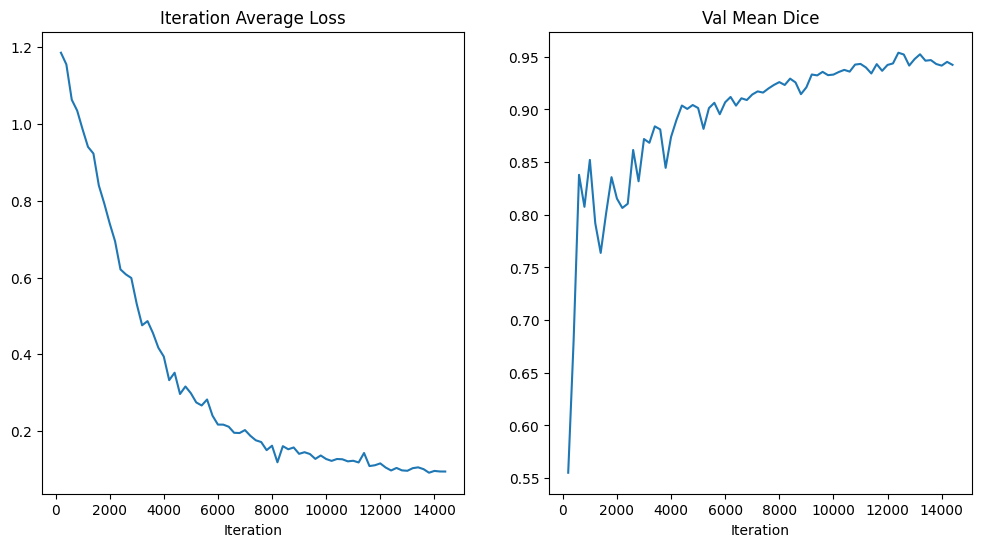

In [ ]:
# plot loss

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
#CHANGE PER MODEL
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values_vnet_withaug))]
#CHANGE PER MODEL
y = epoch_loss_values_vnet_withaug
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
#CHANGE PER MODEL
x = [eval_num * (i + 1) for i in range(len(metric_values_vnet_withaug))]
#CHANGE PER MODEL
y = metric_values_vnet_withaug
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

# Save the metric values and epoch loss values to separate files
#CHANGE PER MODEL
np.save(os.path.join(root_dir, (roi_type + "metric_values_vnet_withaug.npy")), np.array(metric_values_vnet_withaug))
#CHANGE PER MODEL
np.save(os.path.join(root_dir, (roi_type + "epoch_loss_values_vnet_withaug.npy")), np.array(epoch_loss_values_vnet_withaug))

In [ ]:
torch.save(model.state_dict(), os.path.join(root_dir, (roi_type+"vnet_withaug_best_metric_model.pth")))
model.load_state_dict(torch.load(os.path.join(root_dir, (roi_type+"vnet_withaug_best_metric_model.pth"))))

<All keys matched successfully>

In [ ]:
split_JSON_run = "face-training-1-lab-v1.json"


datasets_run = data_dir + split_JSON_run
val_files_run = load_decathlon_datalist(datasets_run, True, "validation")
val_ds_run = CacheDataset(
    data=val_files_run, transform=val_transforms, cache_num=300, cache_rate=1.0, num_workers=4
)
val_loader_run = DataLoader(
    val_ds_run, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)

Loading dataset: 100%|██████████| 12/12 [00:00<00:00, 30.07it/s]


In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, (roi_type+"vnet_withaug_best_metric_model.pth"))), strict=False)
model.eval()

VNet(
  (in_tr): InputTransition(
    (act_function): ELU(alpha=1.0, inplace=True)
    (conv_block): Convolution(
      (conv): Conv3d(1, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2), bias=False)
      (adn): ADN(
        (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (down_tr32): DownTransition(
    (down_conv): Conv3d(16, 32, kernel_size=(2, 2, 2), stride=(2, 2, 2), bias=False)
    (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_function1): ELU(alpha=1.0, inplace=True)
    (act_function2): ELU(alpha=1.0, inplace=True)
    (ops): Sequential(
      (0): LUConv(
        (act_function): ELU(alpha=1.0, inplace=True)
        (conv_block): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2), bias=False)
          (adn): ADN(
            (N): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

0 261-img.nii.gz


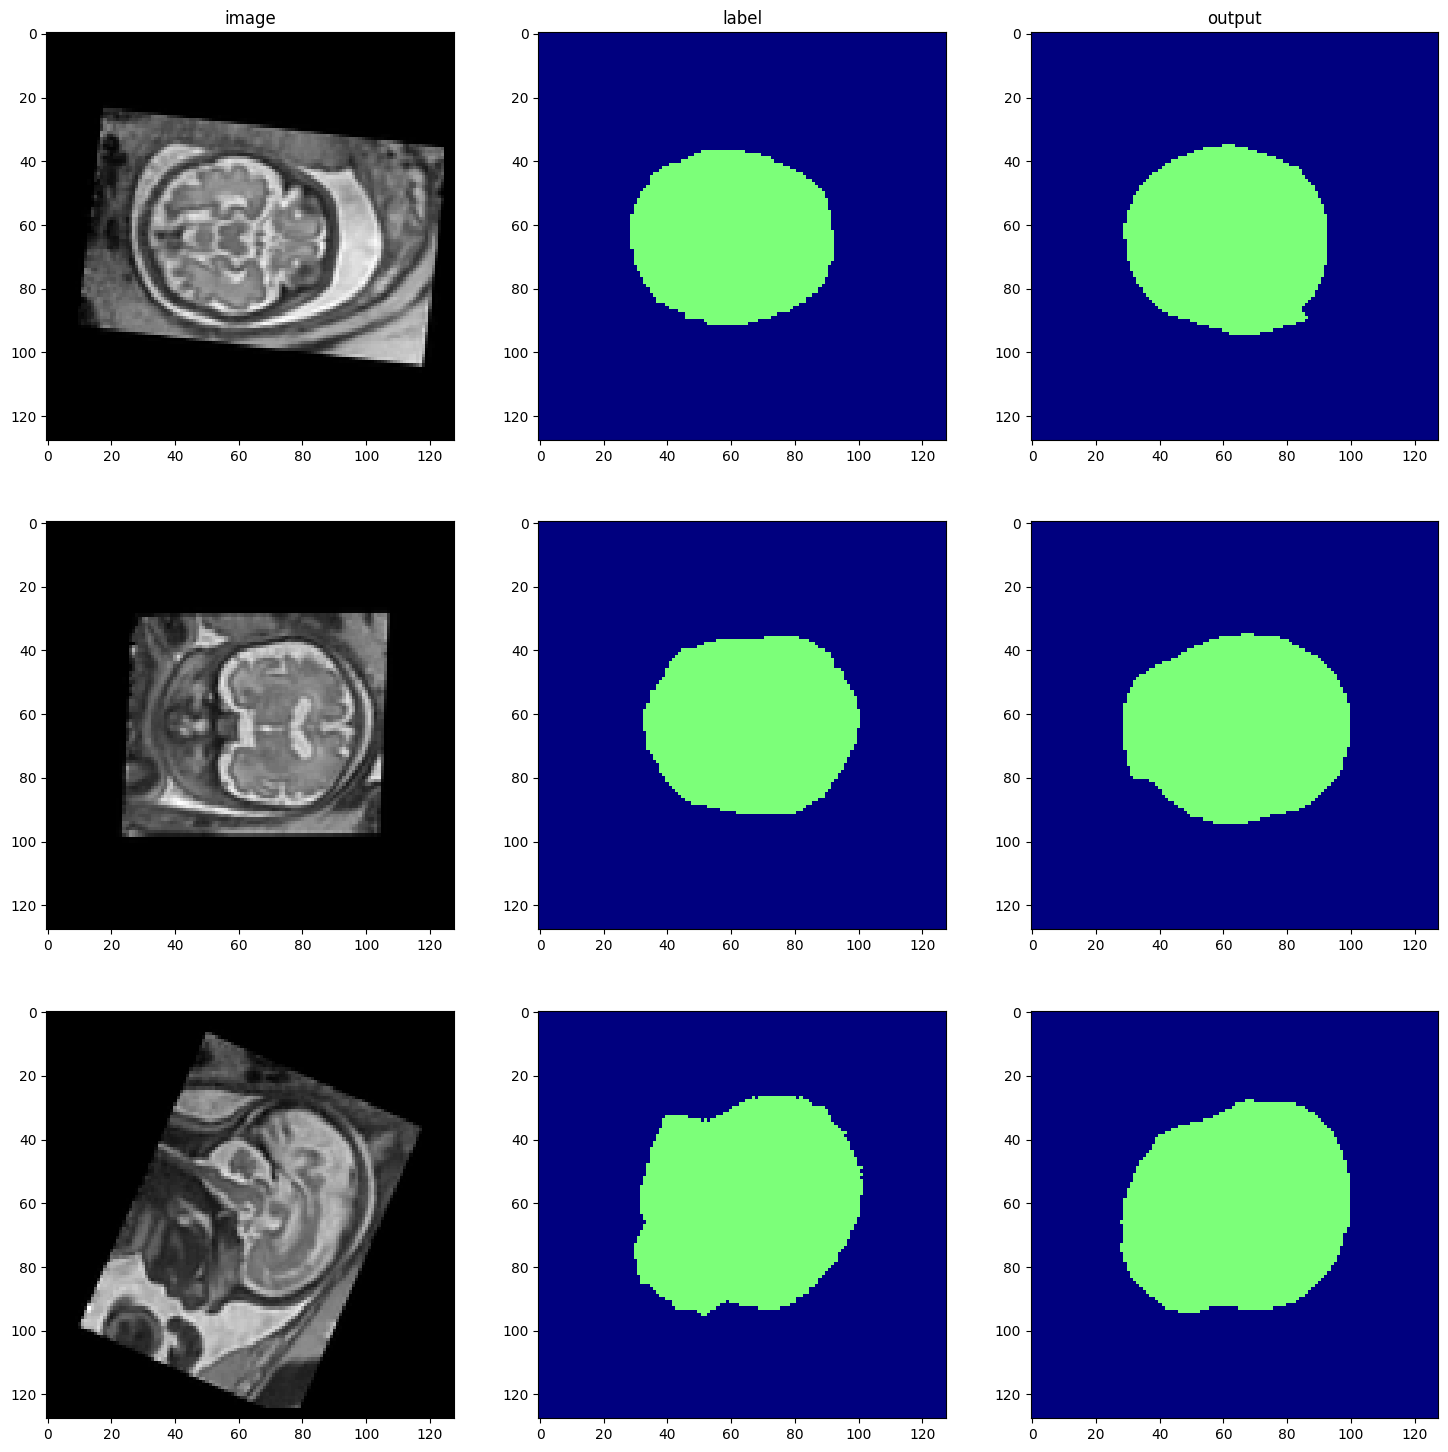

1 335-img.nii.gz


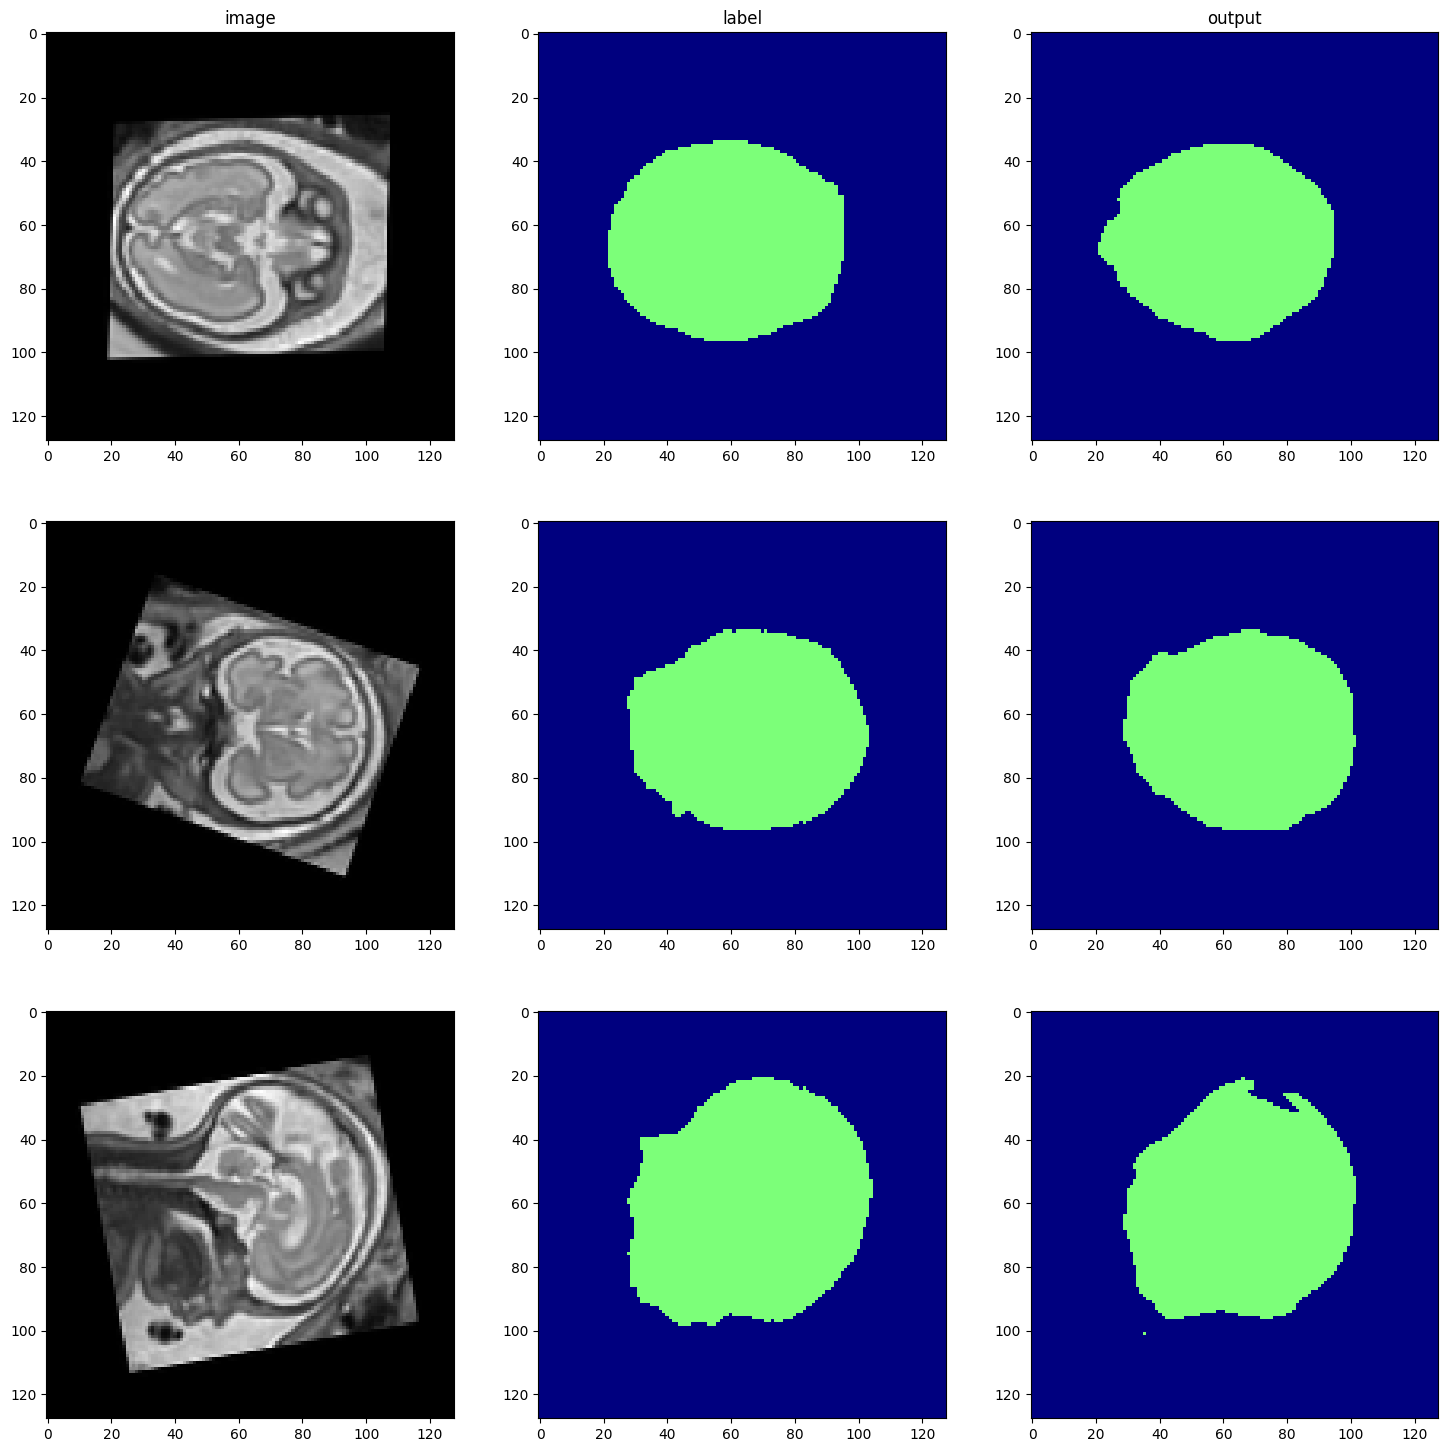

2 426-img.nii.gz


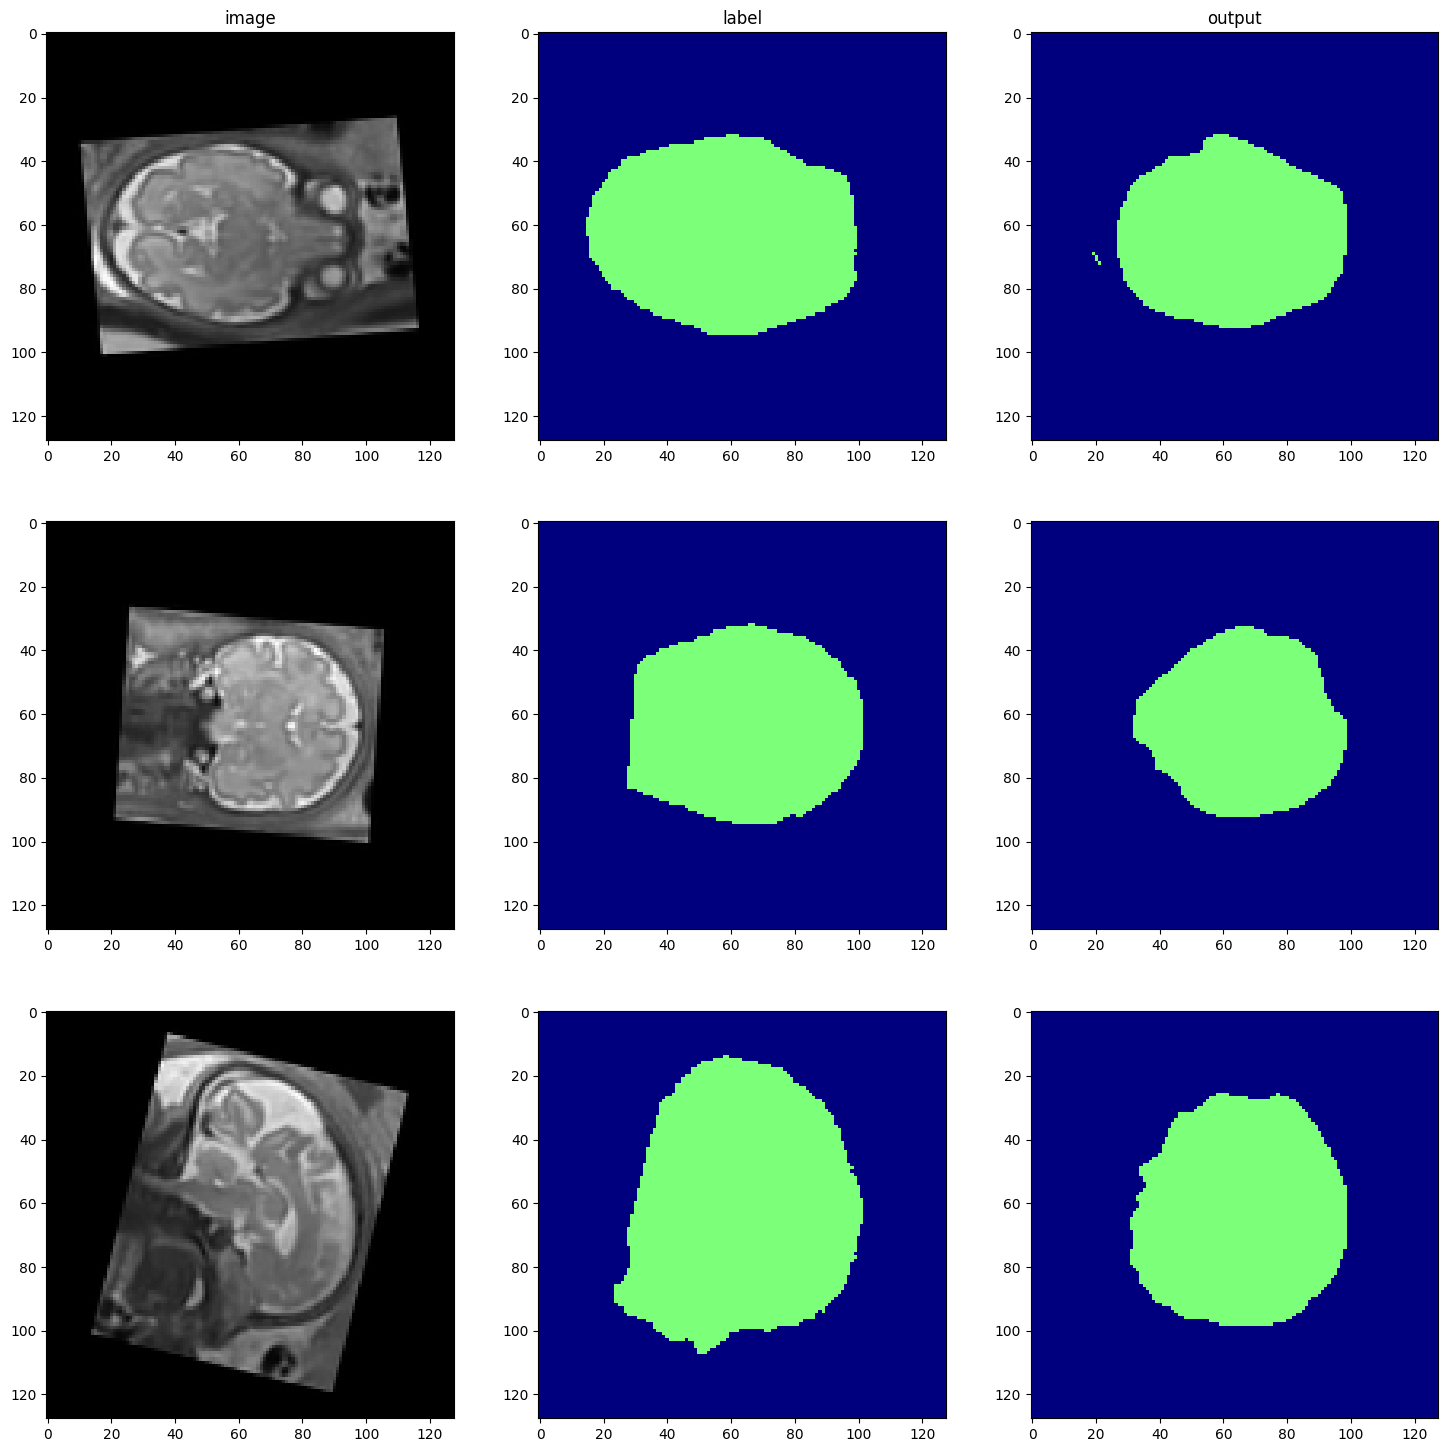

3 342-img.nii.gz


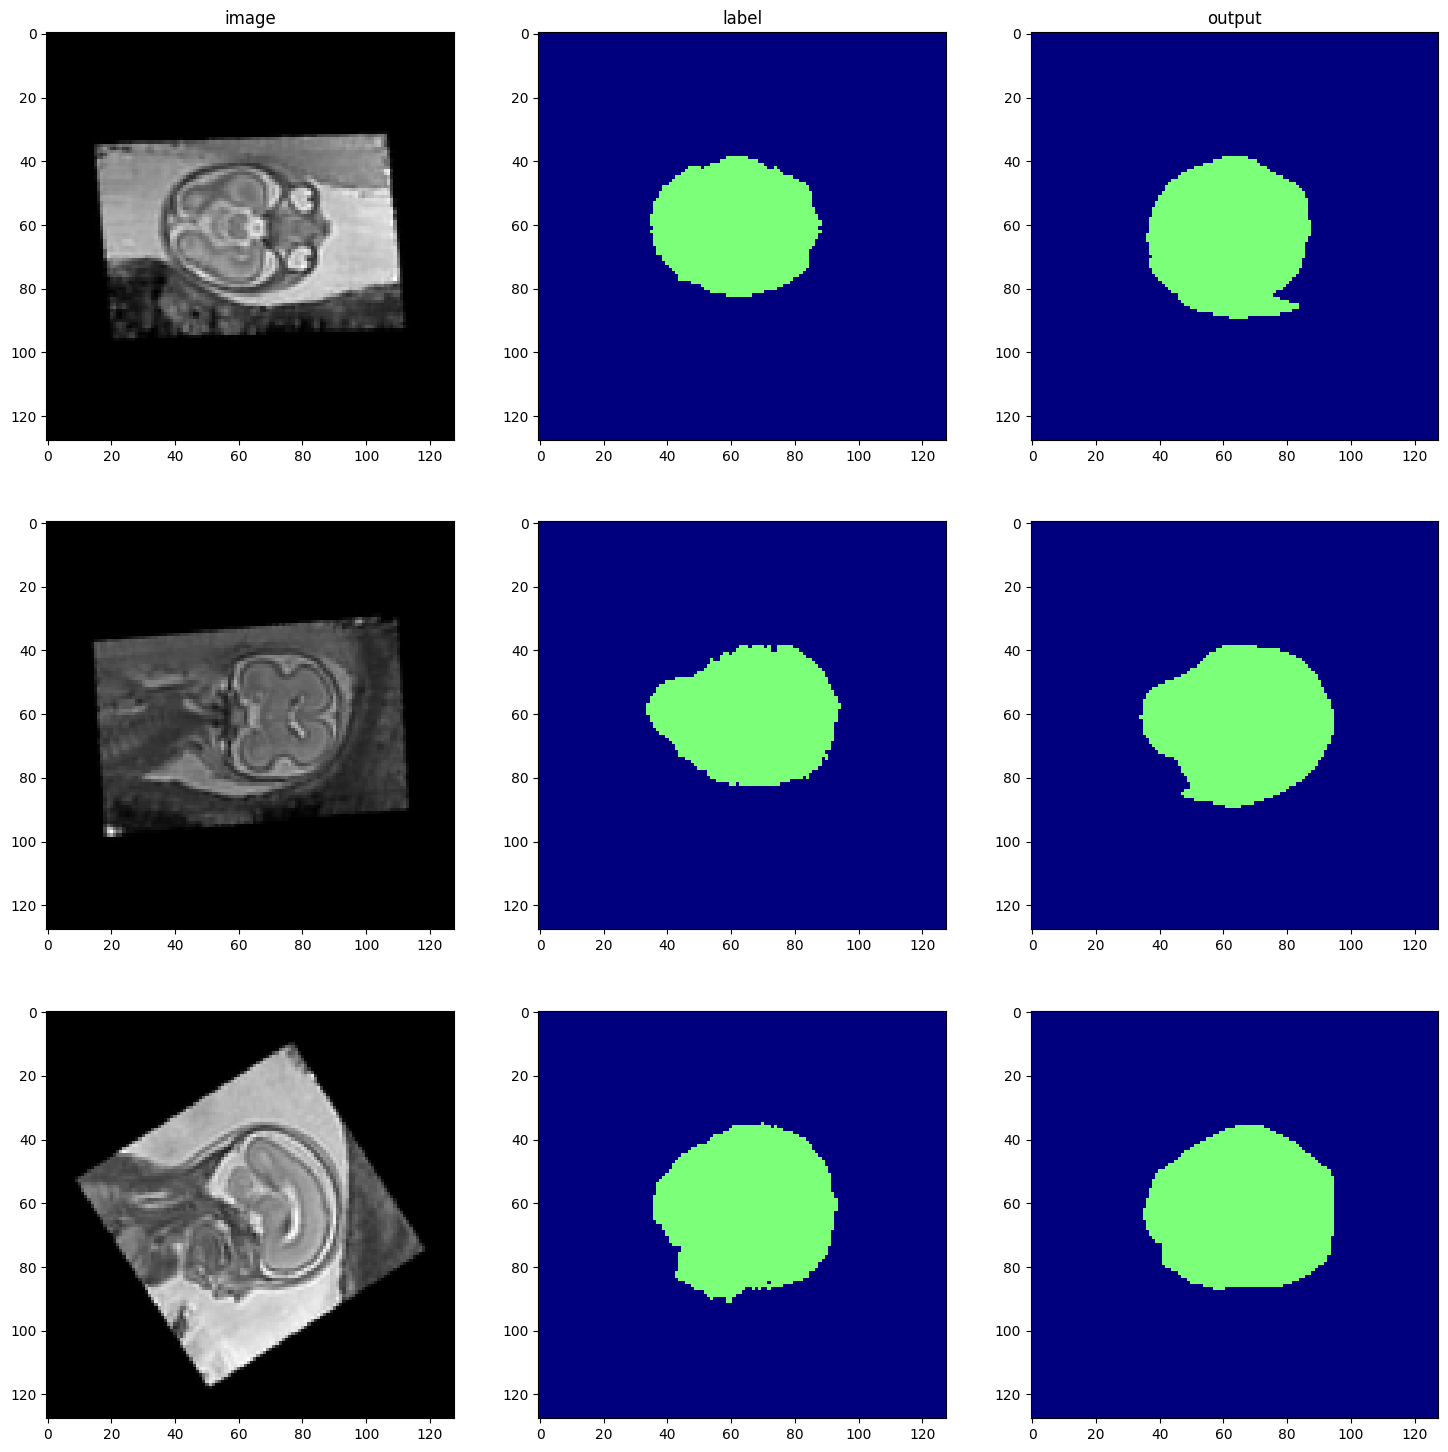

4 435-img.nii.gz


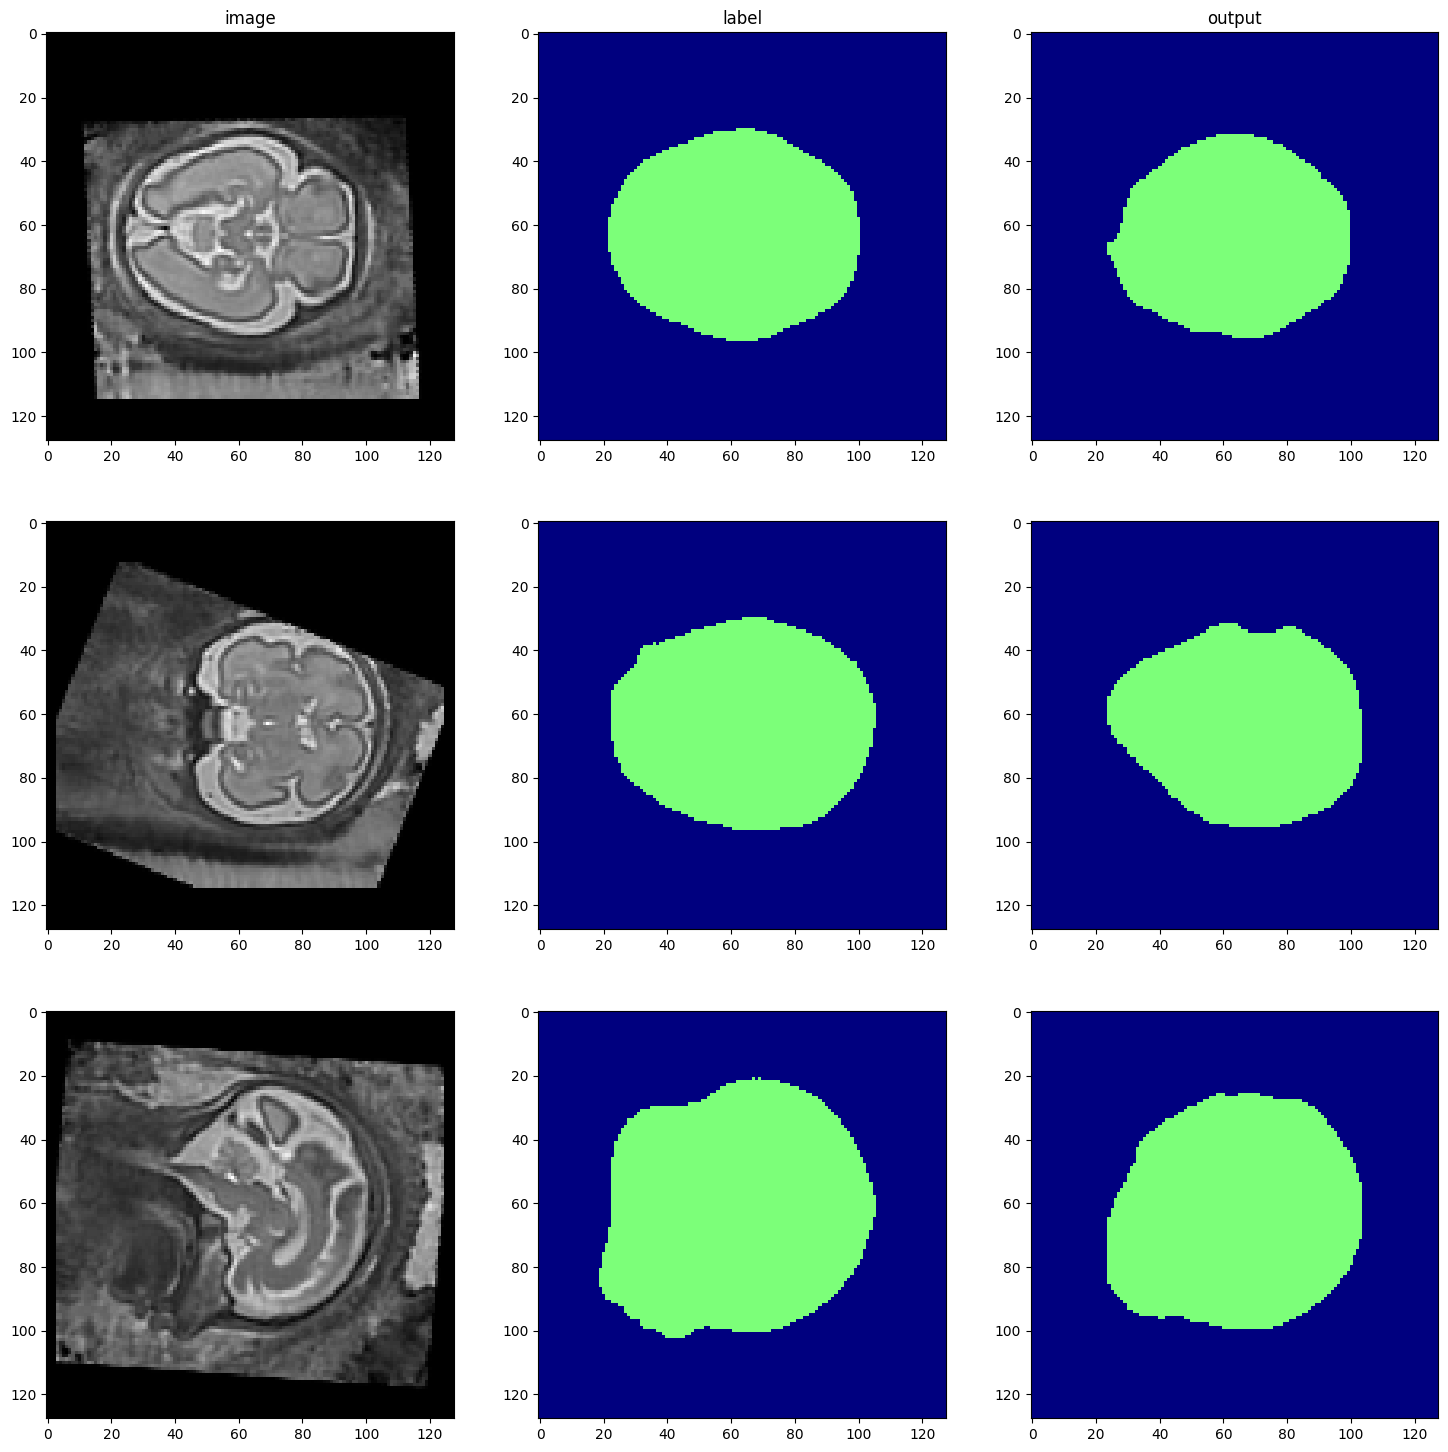

5 hist-136-img.nii.gz


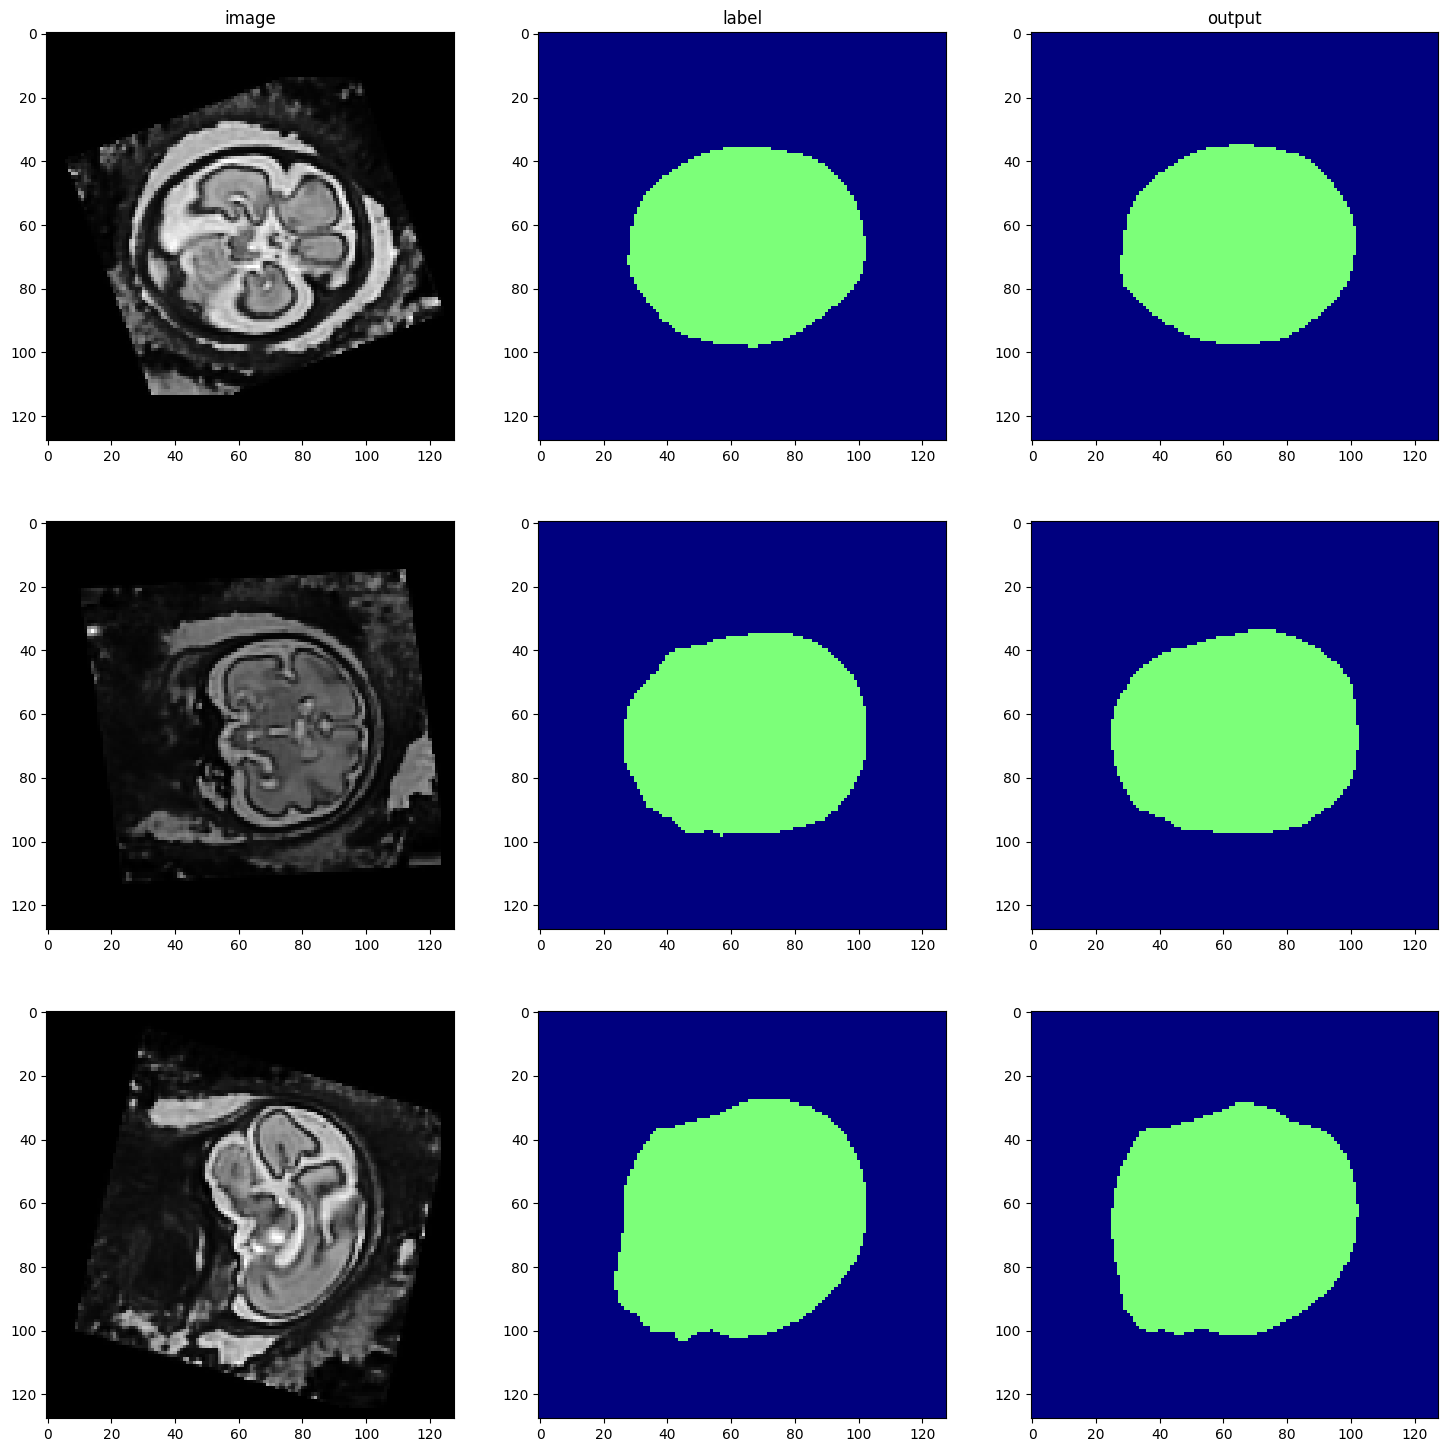

6 hist-214-img.nii.gz


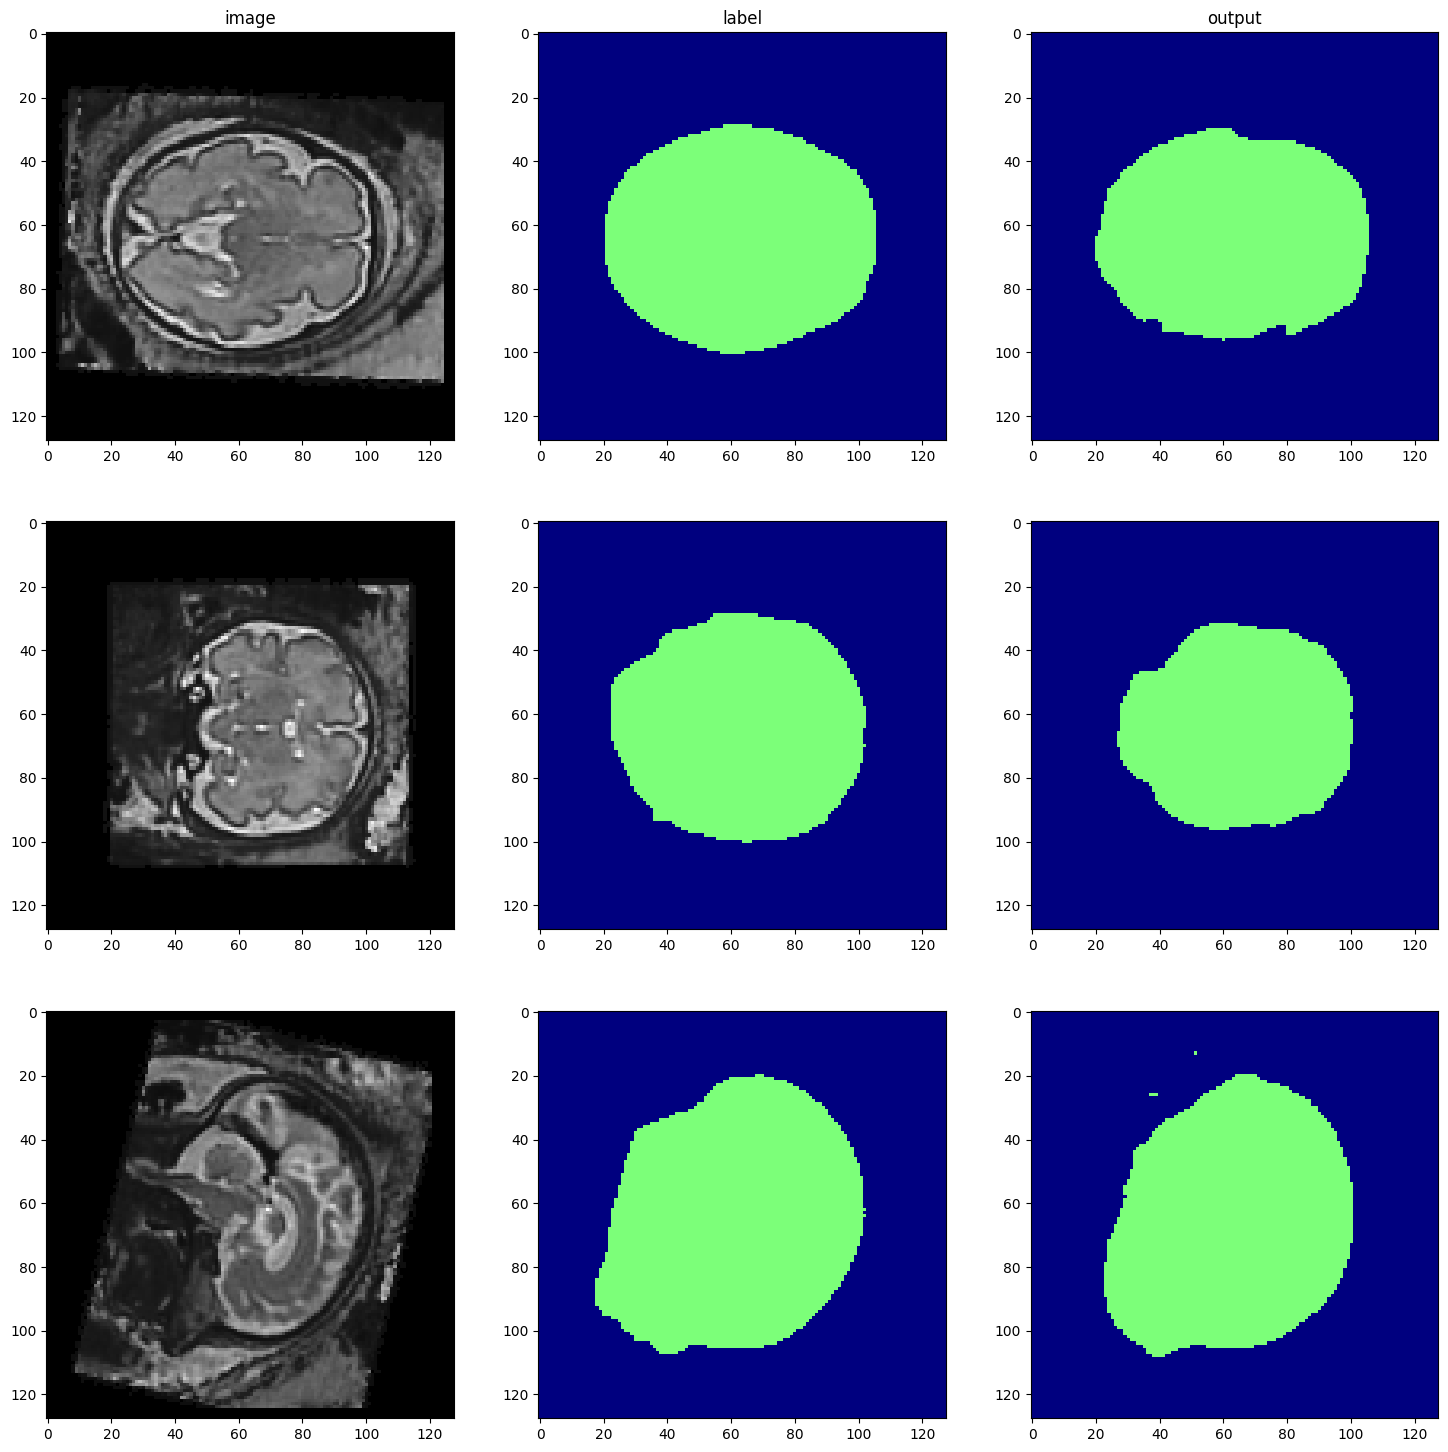

7 hist-236-img.nii.gz


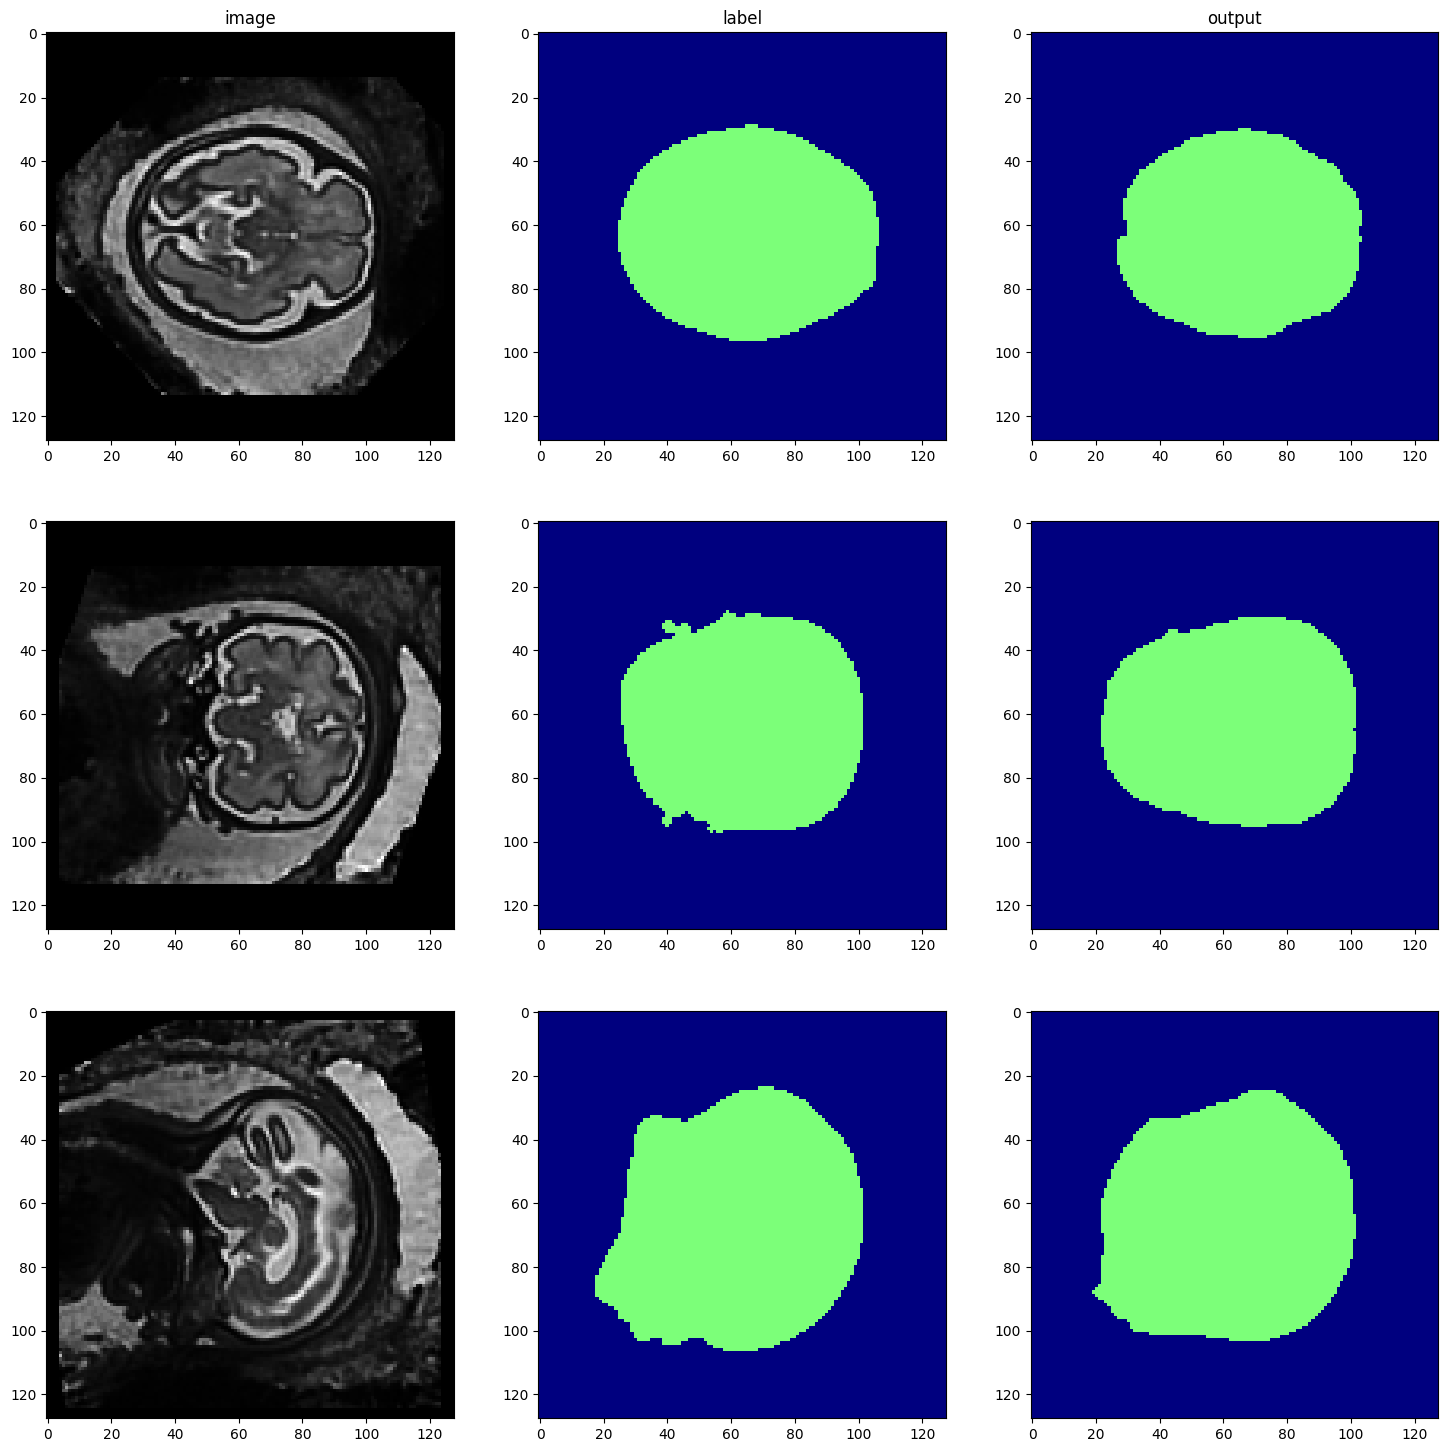

8 hist-253-img.nii.gz


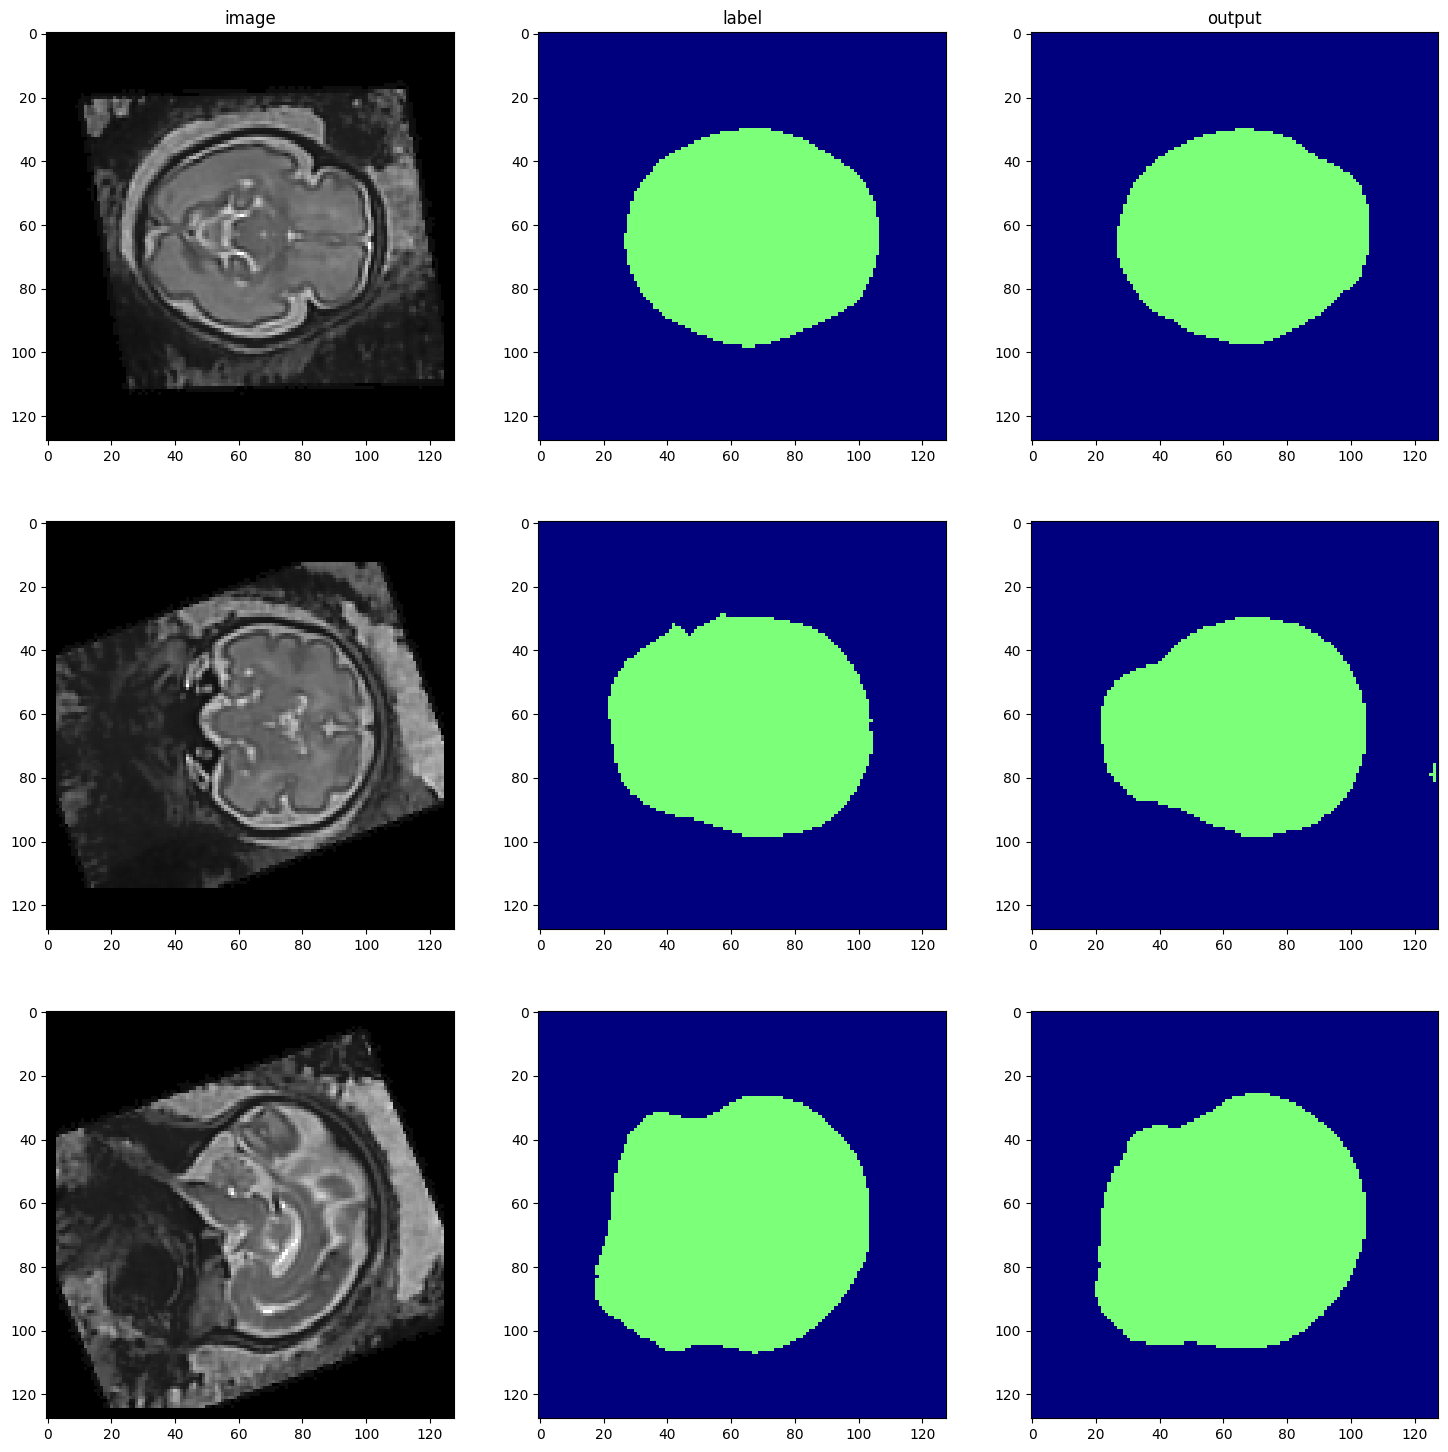

9 hist-275-img.nii.gz


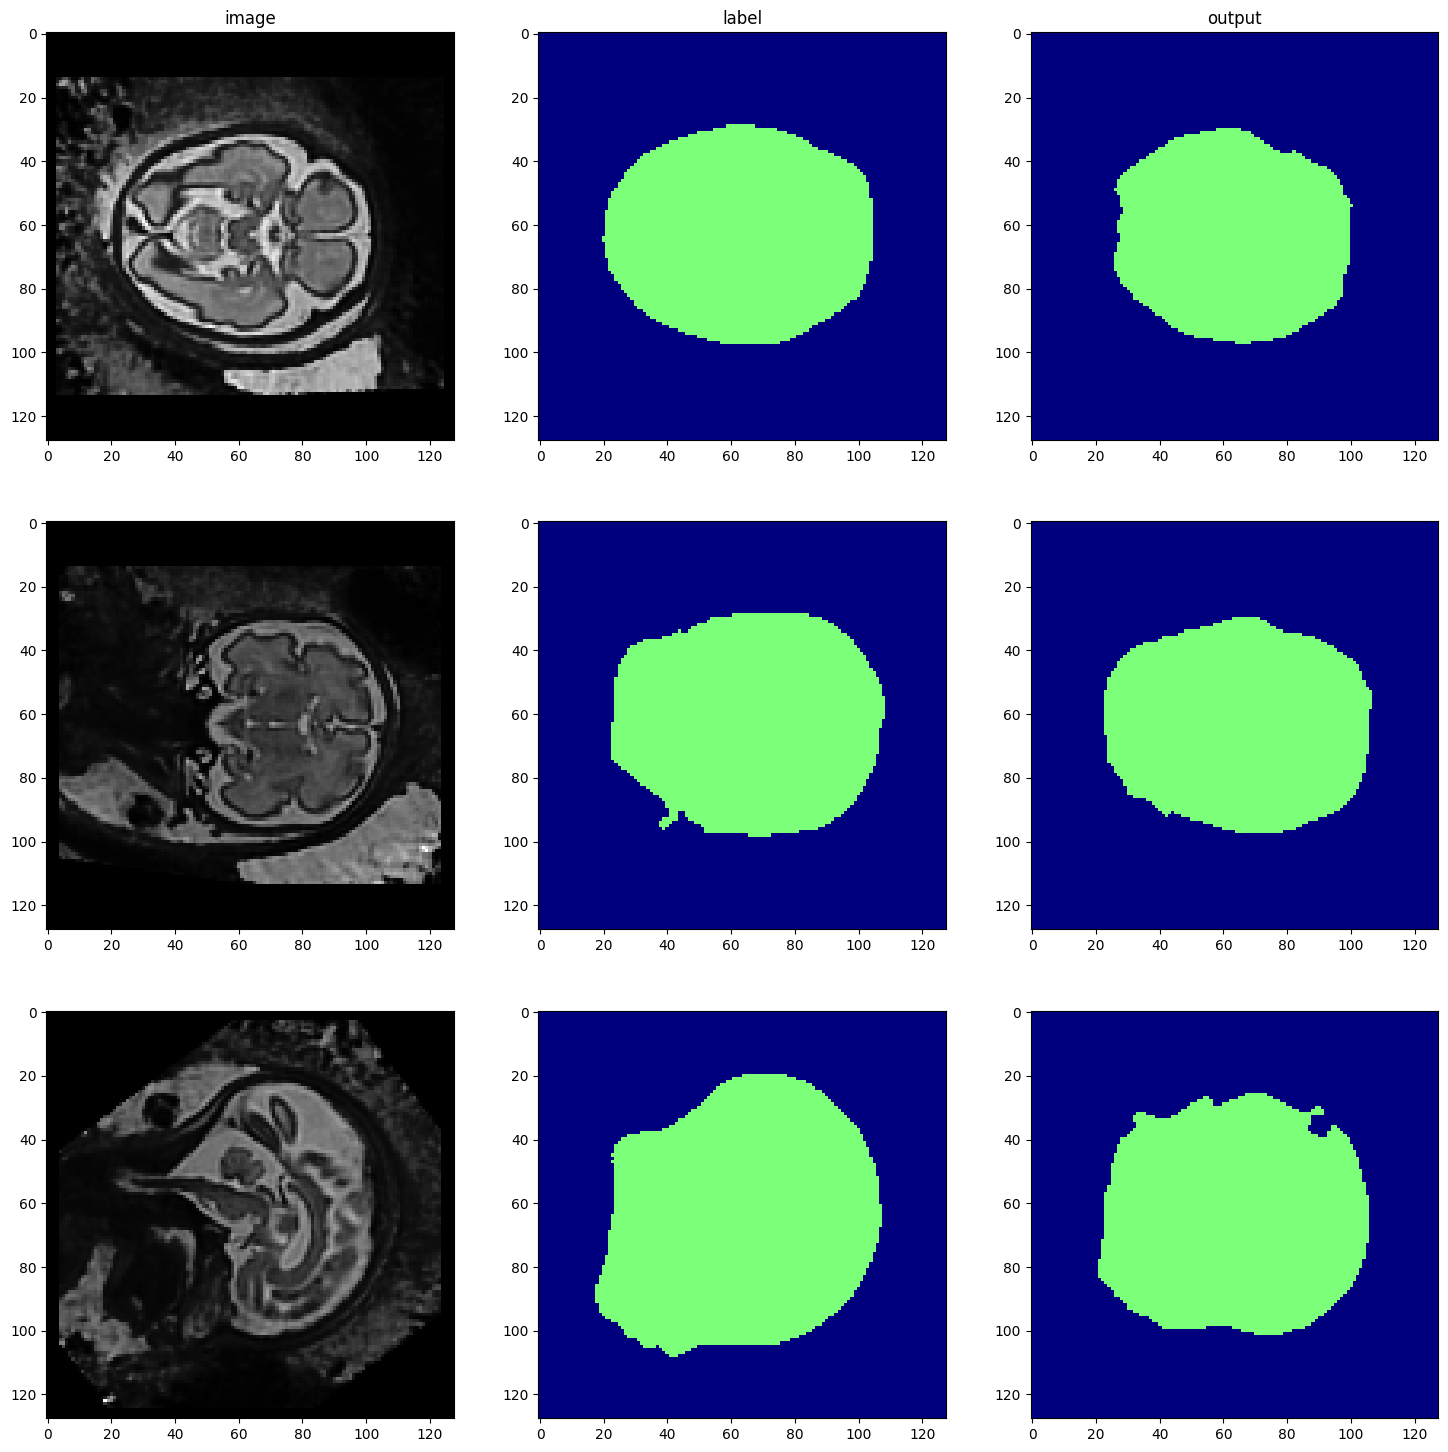

10 hist-292-img.nii.gz


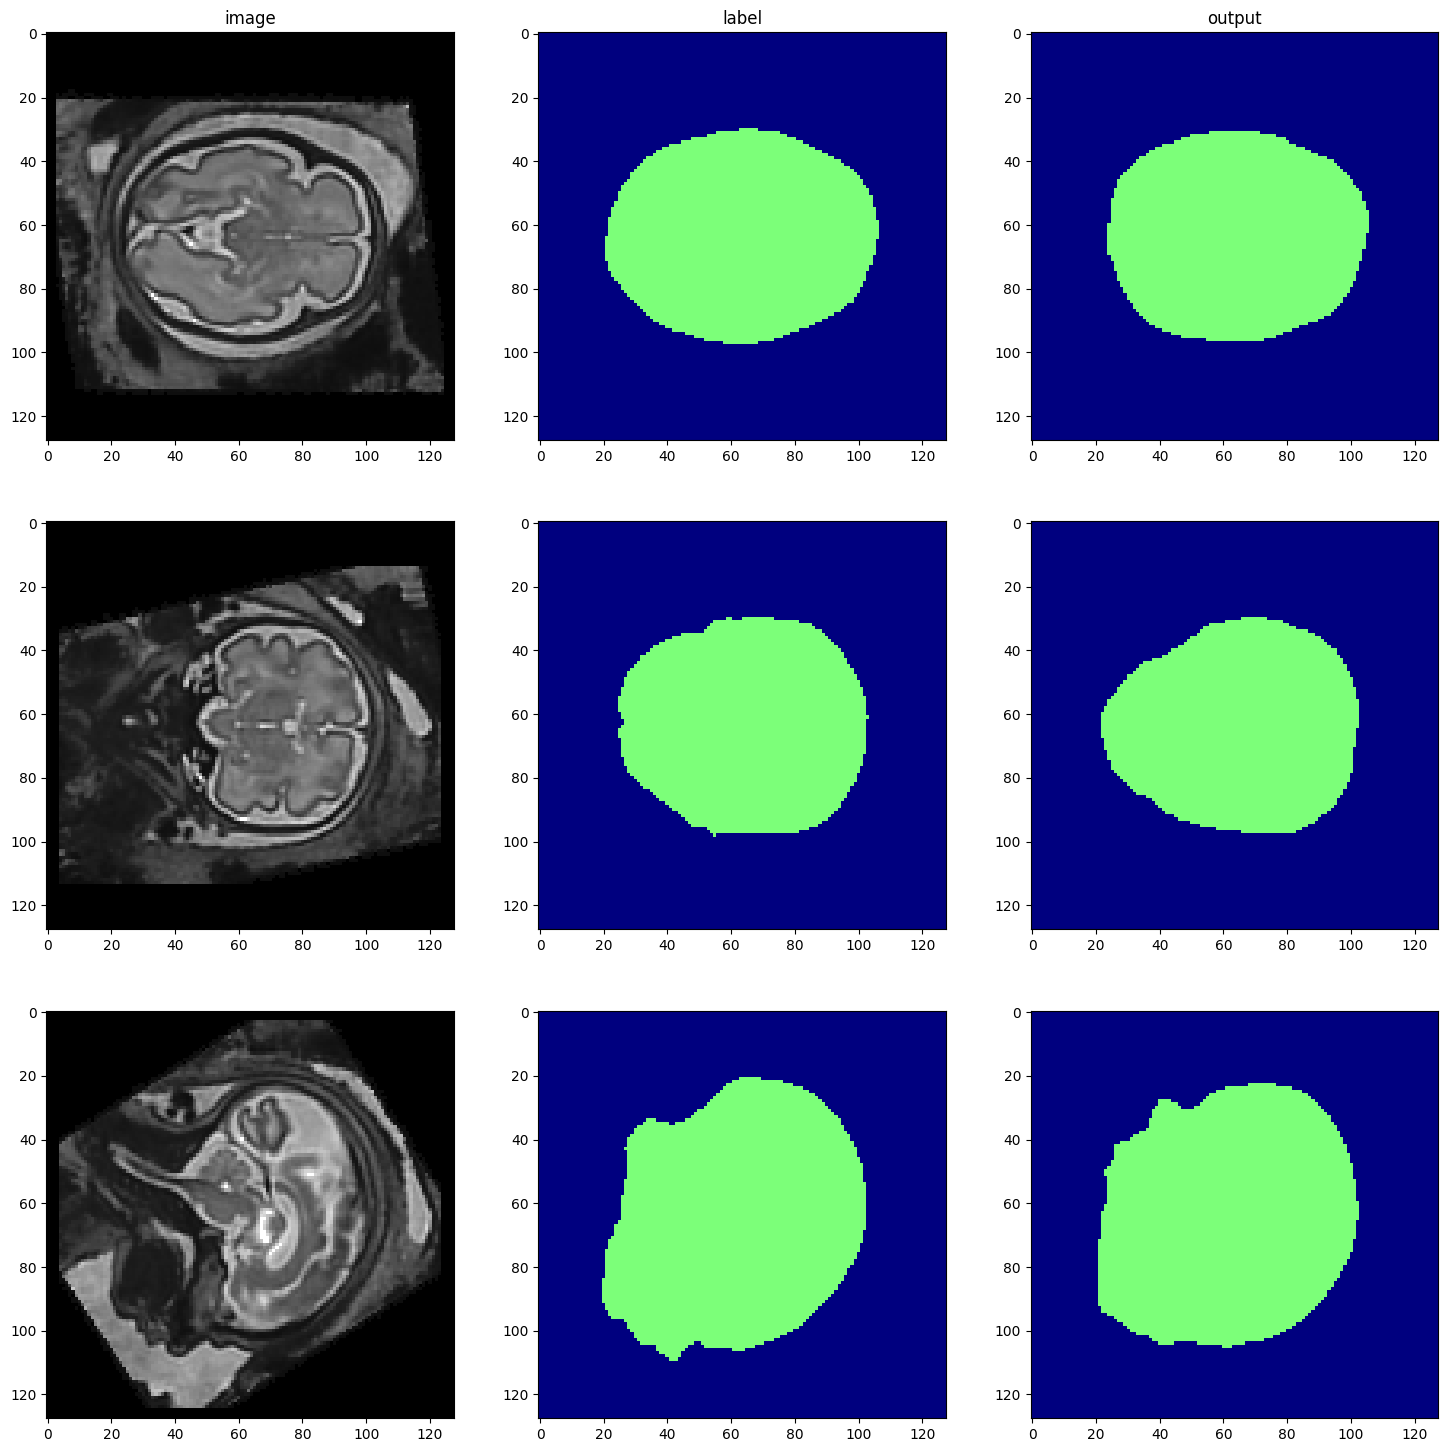

11 hist-355-img.nii.gz


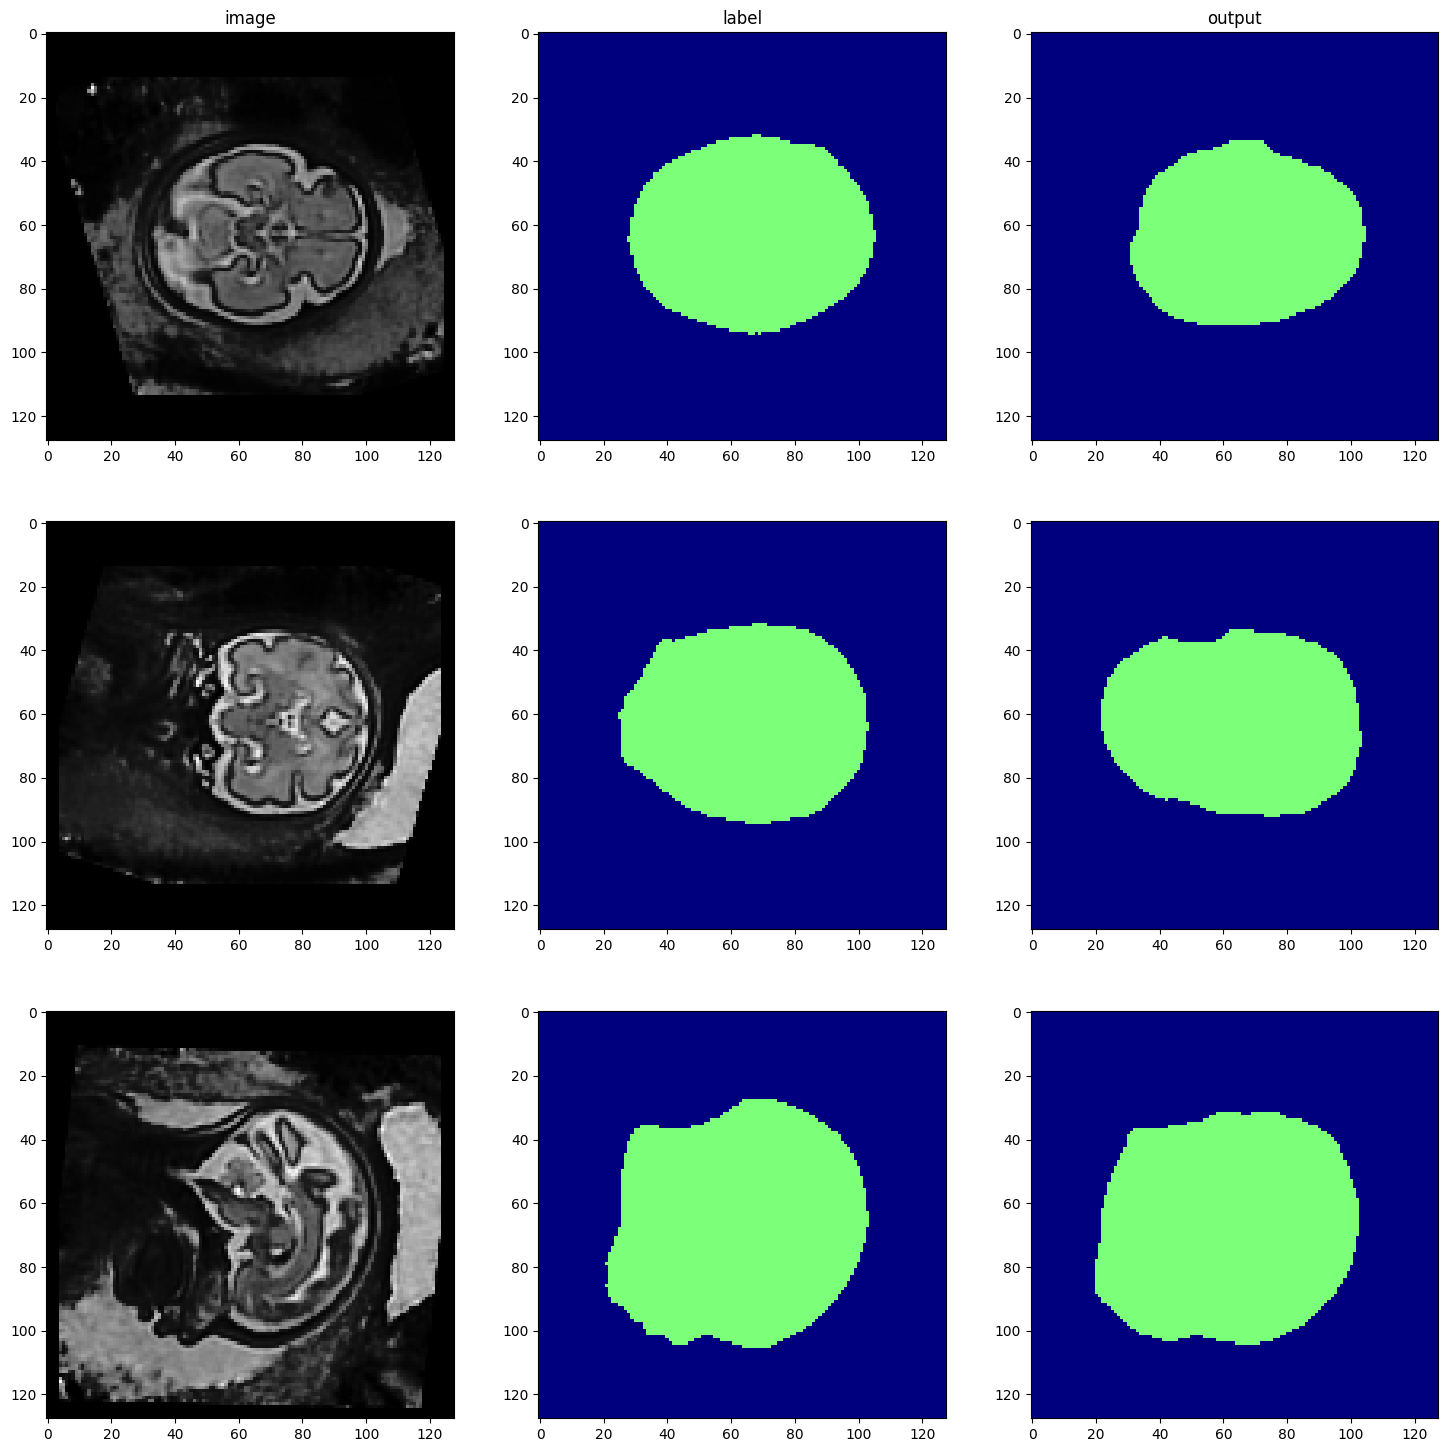

In [ ]:
class_n = class_num
qq=round(img_dim/2)

for x in range(len(val_files_run)):

  case_num = x
  with torch.no_grad():
      img_name = os.path.split(val_ds_run[case_num]["image_meta_dict"]["filename_or_obj"])[1]
      cur_case = val_ds_run[case_num]
      img = cur_case["image"]
      label = cur_case["label"]
      val_inputs = torch.unsqueeze(img, 1).cuda()
      val_labels = torch.unsqueeze(label, 1).cuda()
      val_outputs = sliding_window_inference(
          val_inputs, (img_dim, img_dim, img_dim), 4, model, overlap=0.8
      )

      print(x,img_name)

      plt.figure("check", (18, 18))
      plt.subplot(3, 3, 1)
      plt.title("image")
      plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
      plt.subplot(3, 3, 2)
      plt.title("label")
      plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, qq], vmin=0, vmax=class_n, cmap="jet")
      plt.subplot(3, 3, 3)
      plt.title("output")
      plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, qq], vmin=0, vmax=class_n, cmap="jet")

      plt.subplot(3, 3, 4)
      plt.imshow(val_inputs.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
      plt.subplot(3, 3, 5)
      plt.imshow(val_labels.cpu().numpy()[0, 0, :, qq, :], vmin=0, vmax=class_n, cmap="jet")
      plt.subplot(3, 3, 6)
      plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, qq, :], vmin=0, vmax=class_n, cmap="jet")


      plt.subplot(3, 3, 7)
      plt.imshow(val_inputs.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
      plt.subplot(3, 3, 8)
      plt.imshow(val_labels.cpu().numpy()[0, 0, qq, :, :], vmin=0, vmax=class_n, cmap="jet")
      plt.subplot(3, 3, 9)
      plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, qq, :, :], vmin=0, vmax=class_n, cmap="jet")

      plt.show()

In [ ]:
# save cnn segmentation results for all validation images


res_dir = root_dir + "/" + roi_type + "vnet_withaug_results"

isdir = os.path.isdir(res_dir)
if not isdir:
  os.mkdir(res_dir)


for x in range(len(val_files_run)):

  case_num = x
  img_name = val_files_run[case_num]["label"]
  label_name = val_files_run[case_num]["label"]
  case_name = os.path.split(val_ds_run[case_num]["image_meta_dict"]["filename_or_obj"])[1]
  out_name = res_dir + "/cnn-lab-" + case_name
  print(case_num, out_name)

  img_tmp_info = nib.load(img_name)

  with torch.no_grad():
      img_name = os.path.split(val_ds_run[case_num]["image_meta_dict"]["filename_or_obj"])[1]
      img = val_ds_run[case_num]["image"]
      label = val_ds_run[case_num]["label"]
      val_inputs = torch.unsqueeze(img, 1).cuda()
      val_labels = torch.unsqueeze(label, 1).cuda()
      val_outputs = sliding_window_inference(
          val_inputs, (img_dim, img_dim, img_dim), 4, model, overlap=0.8
      )

      out_label = torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, :]
      out_lab_nii = nib.Nifti1Image(out_label, img_tmp_info.affine, img_tmp_info.header)
      nib.save(out_lab_nii, out_name)

0 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_vnet_withaug_results/cnn-lab-261-img.nii.gz
1 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_vnet_withaug_results/cnn-lab-335-img.nii.gz
2 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_vnet_withaug_results/cnn-lab-426-img.nii.gz
3 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_vnet_withaug_results/cnn-lab-342-img.nii.gz
4 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_vnet_withaug_results/cnn-lab-435-img.nii.gz
5 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_vnet_withaug_results/cnn-lab-hist-136-img.nii.gz
6 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_vnet_withaug_results/cnn-lab-hist-214-img.nii.gz
7 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_vnet_withaug_results/cnn-lab-hist-236-img.nii.gz
8 /content/drive/MyDrive/face-seg-project-2023/ne